# Environment Setup

In [ ]:
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random

train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'

col_names = ["duration","protocol_type","service","flag","src_bytes",
      "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
      "logged_in","num_compromised","root_shell","su_attempted","num_root",
      "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
      "is_host_login","is_guest_login","count","srv_count","serror_rate",
      "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
      "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
      "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
      "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
      "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

df = pd.read_csv(train_url, header=None, names=col_names)
df_test = pd.read_csv(test_url, header=None, names=col_names)

print('Dimensions of the Training set:', df.shape)
print('Dimensions of the Test set:', df_test.shape)


Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


Testing whether dataset is ready or not

In [ ]:
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
print('Label distribution Training set:')
print(df['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())

Label distribution Training set:
label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

Label distribution Test set:
label
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattac

In [ ]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

# Data pre-processing

Step 1: Data pre-processing

One-Hot-Encoding is used to convert all categorical features into binary features. One-Hot-Endcoding requirement is that the input to this transformer must be an integer matrix expressing the values ​​taken with categorical (discrete) properties. The output will be a sparse matrix where each column corresponds to a possible value. It is assumed that the input properties have values ​​in the range [0, n_values]. Therefore, to convert each category to a number, the properties must first be converted with LabelEncoder.

In [ ]:
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
service
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: count, dtype: int64


In [ ]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


Label the Protocals

In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']

df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]

df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


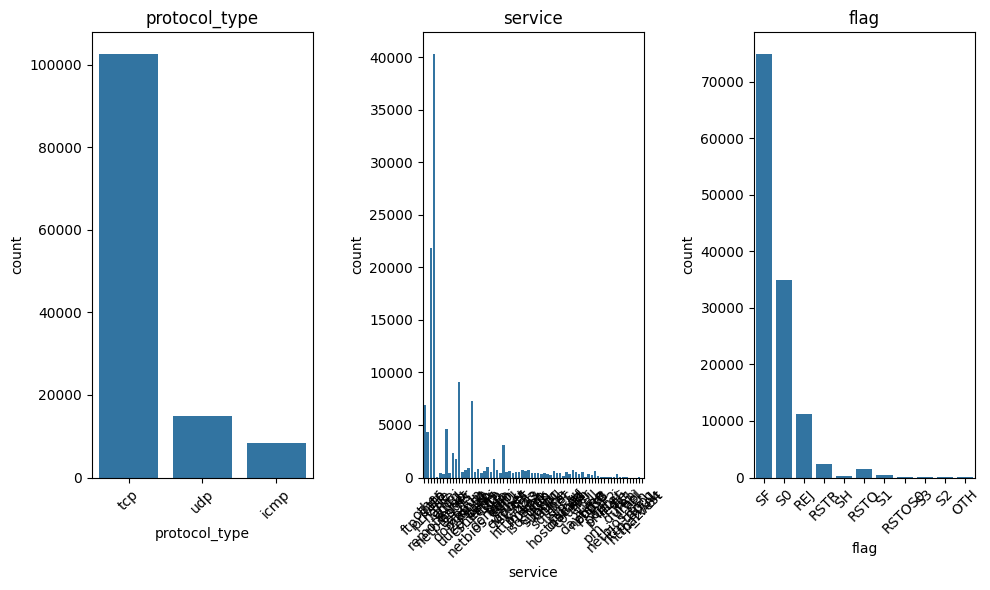

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
for i, column in enumerate(df_categorical_values.columns):
    plt.subplot(1, 3, i+1)
    sns.countplot(data=df_categorical_values, x=column)
    plt.title(column)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Make column names for dummies

In [ ]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
print(unique_protocol2)

# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
print(unique_service2)


# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
print(unique_flag2)


# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2


#do it for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2
print('-------------------------------------')

df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)

print(df_categorical_values.head())
print('--------------------')
print(df_categorical_values_enc.head())

# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp']
['service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'ser

One-Hot-Encoding

In [ ]:
enc = OneHotEncoder(categories='auto')
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)


# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Missing columns in the test set are added

In [ ]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference


['service_http_2784',
 'service_harvest',
 'service_aol',
 'service_red_i',
 'service_http_8001',
 'service_urh_i']

In [ ]:
for col in difference:
    testdf_cat_data[col] = 0

print(df_cat_data.shape)
print(testdf_cat_data.shape)

newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)

# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)

print(newdf.shape)
print(newdf_test.shape)

(125973, 84)
(22544, 84)
(125973, 123)
(22544, 123)


In [ ]:
for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape

(22544, 84)

**Join encoded categorical dataframe with the non-categorical dataframe**

In [ ]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)

# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)

print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


**Split Dataset into 4 datasets for every attack category
Rename every attack label: 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R.  **

Replace labels column with new labels column
Make new datasets

In [ ]:
labeldf=newdf['label']
labeldf_test=newdf_test['label']


# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})



# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test

to_drop_DoS = [0,1]
to_drop_Probe = [0,2]
to_drop_R2L = [0,3]
to_drop_U2R = [0,4]

# Filter all rows with label value other than itself
# isin filter function

DoS_df=newdf[newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[newdf['label'].isin(to_drop_U2R)];



#test
DoS_df_test=newdf_test[newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[newdf_test['label'].isin(to_drop_U2R)];


print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print()
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)

Test:
Dimensions of DoS: (17171, 123)
Dimensions of Probe: (12132, 123)
Dimensions of R2L: (12596, 123)
Dimensions of U2R: (9778, 123)


Step 2: Feature Scaling:

Save a list of feature names for later use (it is the same for every attack category). Column names are dropped at this stage.

In [ ]:
X_DoS = DoS_df.drop('label', axis=1)
Y_DoS = DoS_df['label']

X_Probe = Probe_df.drop('label', axis=1)
Y_Probe = Probe_df['label']

X_R2L = R2L_df.drop('label', axis=1)
Y_R2L = R2L_df['label']

X_U2R = U2R_df.drop('label', axis=1)
Y_U2R = U2R_df['label']

# test set
X_DoS_test = DoS_df_test.drop('label', axis=1)
Y_DoS_test = DoS_df_test['label']

X_Probe_test = Probe_df_test.drop('label', axis=1)
Y_Probe_test = Probe_df_test['label']

X_R2L_test = R2L_df_test.drop('label', axis=1)
Y_R2L_test = R2L_df_test['label']

X_U2R_test = U2R_df_test.drop('label', axis=1)
Y_U2R_test = U2R_df_test['label']

**Since the column names will be deleted at this stage, we save the column names for later use**.

In [ ]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

In [ ]:
from sklearn import preprocessing

scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS)

scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe)

scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L)

scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R)

# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test)

scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test)

scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test)

scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test)


**Check that the Standard Deviation is 1**

In [ ]:
print(X_DoS.std(axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1.]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


data = [X_DoS, X_Probe, X_R2L, X_U2R]
labels = ['DoS', 'Probe', 'R2L', 'U2R']

plt.figure(figsize=(10, 6))
for i in range(len(data)):
    plt.subplot(2, 2, i+1)
    sns.violinplot(data=data[i], inner="quartile")
    plt.title(labels[i])
plt.tight_layout()
plt.show()


# Random Forest

**Step 3: Feature Selection**:
**Recursive Feature Elimination (RFE), top 13 features (as a group)**

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(n_estimators=10,n_jobs=2)
rfe = RFE(estimator=clf, n_features_to_select=13, step=1)

rfe.fit(X_DoS, Y_DoS.astype(int))
X_rfeDoS=rfe.transform(X_DoS)
true=rfe.support_
rfecolindex_DoS=[i for i, x in enumerate(true) if x]
rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)

rfe.fit(X_Probe, Y_Probe.astype(int))
X_rfeProbe=rfe.transform(X_Probe)
true=rfe.support_
rfecolindex_Probe=[i for i, x in enumerate(true) if x]
rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

rfe.fit(X_R2L, Y_R2L.astype(int))
X_rfeR2L=rfe.transform(X_R2L)
true=rfe.support_
rfecolindex_R2L=[i for i, x in enumerate(true) if x]
rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)

rfe.fit(X_U2R, Y_U2R.astype(int))
X_rfeU2R=rfe.transform(X_U2R)
true=rfe.support_
rfecolindex_U2R=[i for i, x in enumerate(true) if x]
rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)

Summary of features selected by RFE

In [ ]:
print('Features selected for DoS:',rfecolname_DoS)
print()
print('Features selected for Probe:',rfecolname_Probe)
print()
print('Features selected for R2L:',rfecolname_R2L)
print()
print('Features selected for U2R:',rfecolname_U2R)

Features selected for DoS: ['src_bytes', 'dst_bytes', 'wrong_fragment', 'count', 'srv_count', 'same_srv_rate', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_ecr_i', 'flag_SF']

Features selected for Probe: ['src_bytes', 'dst_bytes', 'count', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_tcp', 'service_http', 'service_private']

Features selected for R2L: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'is_guest_login', 'count', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp_data']

Features selected for U2R: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'num_compromised', 'root_shell', 'num_file_creations', 'count', 'dst_host_cou

In [ ]:
print(X_rfeDoS.shape)
print(X_rfeProbe.shape)
print(X_rfeR2L.shape)
print(X_rfeU2R.shape)


(113270, 13)
(78999, 13)
(68338, 13)
(67395, 13)


**Step 4: Build the model:**

Classifier is trained for all features and for reduced features, for later comparison.

The classifier model itself is stored in the clf variable.

In [ ]:
# all features
clf_DoS=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_Probe=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_R2L=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_U2R=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_Probe.fit(X_Probe, Y_Probe.astype(int))
clf_R2L.fit(X_R2L, Y_R2L.astype(int))
clf_U2R.fit(X_U2R, Y_U2R.astype(int))


# selected features
clf_rfeDoS=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_rfeProbe=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_rfeR2L=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_rfeU2R=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_rfeDoS.fit(X_rfeDoS, Y_DoS.astype(int))
clf_rfeProbe.fit(X_rfeProbe, Y_Probe.astype(int))
clf_rfeR2L.fit(X_rfeR2L, Y_R2L.astype(int))
clf_rfeU2R.fit(X_rfeU2R, Y_U2R.astype(int))

RandomForestClassifier(n_estimators=10, n_jobs=2)

**Step 5: Prediction & Evaluation (validation)**:



**Confusion Matrices**

DOS

In [ ]:
# Apply the classifier we trained to the test data (which it has never seen before)
clf_DoS.predict(X_DoS_test)

# View the predicted probabilities of the first 10 observations
clf_DoS.predict_proba(X_DoS_test)[0:20]

Y_DoS_pred=clf_DoS.predict(X_DoS_test)

# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9659,52
1,4217,3243


Probe

In [ ]:
Y_Probe_pred=clf_Probe.predict(X_Probe_test)
# Create confusion matrix

pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,9490,221
2,1098,1323


R2L

In [ ]:
Y_R2L_pred=clf_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9711
3,2885


U2R

In [ ]:
Y_U2R_pred=clf_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9711
4,67


**Cross Validation: Accuracy, Precision, Recall, F-measure**

DOS
---------------
Accuracy: 99.85440% (+/- 0.20999%)
Precision: 99.82144% (+/- 0.18730%)
Recall: 99.77580% (+/- 0.26446%)
F-measure: 99.78663% (+/- 0.24412%)



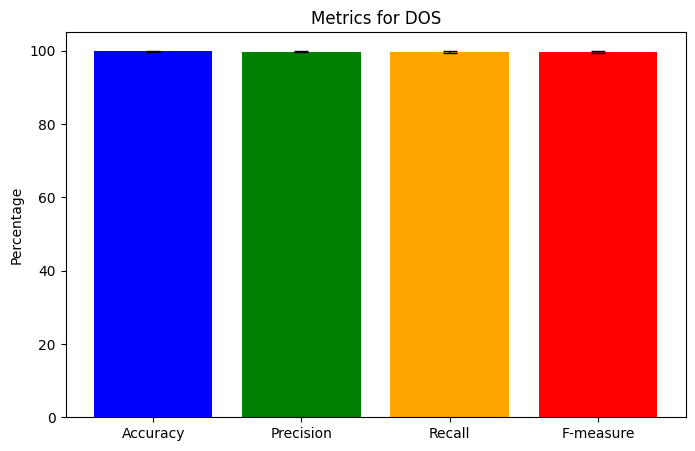

Probe
---------------
Accuracy: 99.68675% (+/- 0.32810%)
Precision: 99.64302% (+/- 0.31361%)
Recall: 99.33407% (+/- 0.51145%)
F-measure: 99.37826% (+/- 0.51614%)



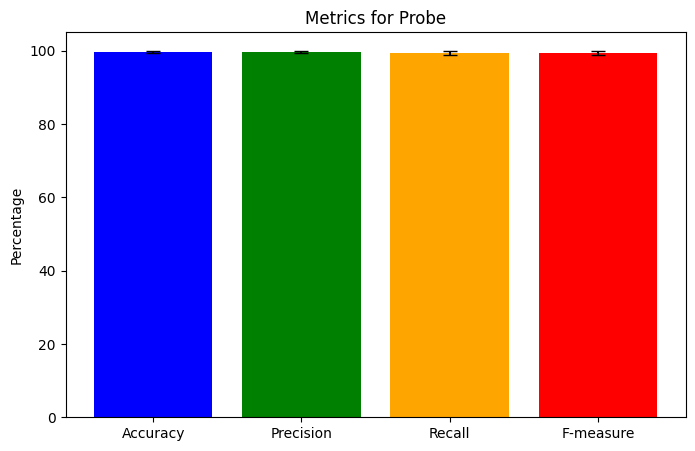

U2R
---------------
Accuracy: 99.78521% (+/- 0.21361%)
Precision: 95.09796% (+/- 10.92955%)
Recall: 87.10167% (+/- 11.91533%)
F-measure: 89.52485% (+/- 11.24255%)



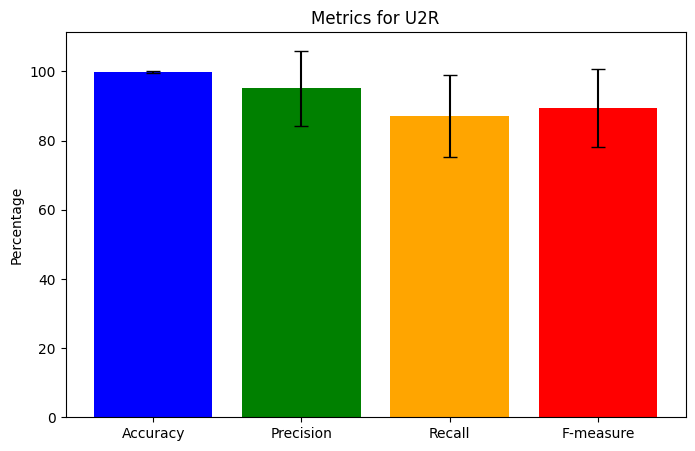

R2L
---------------
Accuracy: 98.07078% (+/- 0.78502%)
Precision: 97.32938% (+/- 0.78767%)
Recall: 96.96189% (+/- 1.22143%)
F-measure: 97.23489% (+/- 0.94432%)



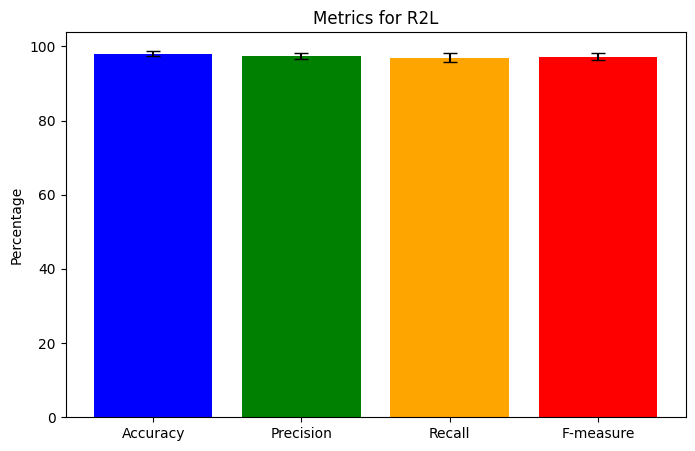

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt

def print_metrics(classifier, X, Y, class_name):
    accuracy = cross_val_score(classifier, X, Y, cv=10, scoring='accuracy')
    precision = cross_val_score(classifier, X, Y, cv=10, scoring='precision_macro')
    recall = cross_val_score(classifier, X, Y, cv=10, scoring='recall_macro')
    f_measure = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')

    print(class_name)
    print('---------------')
    print("Accuracy: %0.5f%% (+/- %0.5f%%)" % (accuracy.mean() * 100, accuracy.std() * 200))
    print("Precision: %0.5f%% (+/- %0.5f%%)" % (precision.mean() * 100, precision.std() * 200))
    print("Recall: %0.5f%% (+/- %0.5f%%)" % (recall.mean() * 100, recall.std() * 200))
    print("F-measure: %0.5f%% (+/- %0.5f%%)" % (f_measure.mean() * 100, f_measure.std() * 200))
    print()

    # Plotting
    labels = ['Accuracy', 'Precision', 'Recall', 'F-measure']
    values = [accuracy.mean() * 100, precision.mean() * 100, recall.mean() * 100, f_measure.mean() * 100]
    errors = [accuracy.std() * 200, precision.std() * 200, recall.std() * 200, f_measure.std() * 200]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, yerr=errors, capsize=5, color=['blue', 'green', 'orange', 'red'])
    plt.title(f'Metrics for {class_name}')
    plt.ylabel('Percentage')
    plt.show()

print_metrics(clf_DoS, X_DoS_test, Y_DoS_test, 'DOS')
print_metrics(clf_Probe, X_Probe_test, Y_Probe_test, 'Probe')
print_metrics(clf_U2R, X_U2R_test, Y_U2R_test, 'U2R')
print_metrics(clf_R2L, X_R2L_test, Y_R2L_test, 'R2L')


**Using 13 Features for each category**

In [ ]:

# reduce test dataset to 13 features, use only features described in rfecolname_DoS etc.
X_DoS_test2=X_DoS_test[:,rfecolindex_DoS]
X_Probe_test2=X_Probe_test[:,rfecolindex_Probe]
X_R2L_test2=X_R2L_test[:,rfecolindex_R2L]
X_U2R_test2=X_U2R_test[:,rfecolindex_U2R]
X_U2R_test2.shape

(9778, 13)

In [ ]:
print('DOS')
print('-----------')
Y_DoS_pred2=clf_rfeDoS.predict(X_DoS_test2)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

DOS
-----------


Predicted attacks,0,1
Actual attacks,,
0,9536,175
1,3456,4004


In [ ]:
print('Probe')
print('-----------')
Y_Probe_pred2=clf_rfeProbe.predict(X_Probe_test2)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Probe
-----------


Predicted attacks,0,2
Actual attacks,,
0,9313,398
2,1027,1394


In [ ]:
print('R2L')
print('-----------')
Y_R2L_pred2=clf_rfeR2L.predict(X_R2L_test2)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

R2L
-----------


Predicted attacks,0,3
Actual attacks,,
0,9711,0
3,2878,7


In [ ]:
print('U2R')
print('-----------')
Y_U2R_pred2=clf_rfeU2R.predict(X_U2R_test2)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

U2R
-----------


Predicted attacks,0,4
Actual attacks,,
0,9710,1
4,63,4


# KNeighbors

In [ ]:

from sklearn.neighbors import KNeighborsClassifier

clf_KNN_DoS=KNeighborsClassifier()
clf_KNN_Probe=KNeighborsClassifier()
clf_KNN_R2L=KNeighborsClassifier()
clf_KNN_U2R=KNeighborsClassifier()

clf_KNN_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_KNN_Probe.fit(X_Probe, Y_Probe.astype(int))
clf_KNN_R2L.fit(X_R2L, Y_R2L.astype(int))
clf_KNN_U2R.fit(X_U2R, Y_U2R.astype(int))

KNeighborsClassifier()

In [ ]:
print('DOS')
print('-----------')
Y_DoS_pred=clf_KNN_DoS.predict(X_DoS_test)

# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

DOS
-----------


Predicted attacks,0,1
Actual attacks,,
0,9422,289
1,1573,5887


In [ ]:
print('Probe')
print('-----------')

Y_Probe_pred=clf_KNN_Probe.predict(X_Probe_test)
# Create confusion matrix

pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Probe
-----------


Predicted attacks,0,2
Actual attacks,,
0,9437,274
2,1272,1149


In [ ]:
print('R2L')
print('-----------')

Y_R2L_pred=clf_KNN_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


R2L
-----------


Predicted attacks,0,3
Actual attacks,,
0,9706,5
3,2883,2


In [ ]:
print('U2R')
print('-----------')

Y_U2R_pred=clf_KNN_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

U2R
-----------


Predicted attacks,0,4
Actual attacks,,
0,9711,0
4,65,2


**Cross Validation: Accuracy, Precision, Recall, F-measure**

DOS
---------
Accuracy: 99.71463% (+/- 0.27787%)
Precision: 99.71054% (+/- 0.28611%)
Recall: 99.70886% (+/- 0.28089%)
F-measure: 99.70964% (+/- 0.28271%)



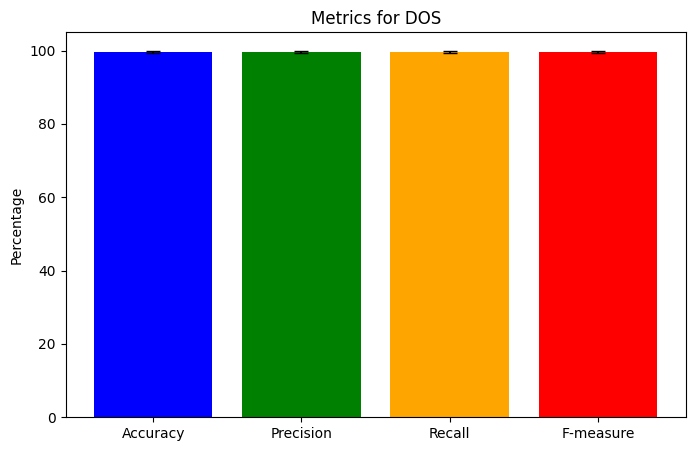

Probe
---------
Accuracy: 99.07681% (+/- 0.40266%)
Precision: 98.60594% (+/- 0.67516%)
Recall: 98.50846% (+/- 1.13667%)
F-measure: 98.55258% (+/- 0.64466%)



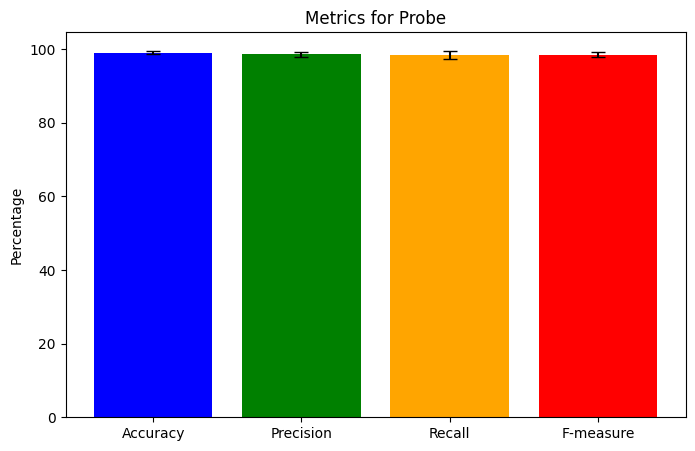

R2L
---------
Accuracy: 96.74500% (+/- 0.73459%)
Precision: 95.32528% (+/- 1.24687%)
Recall: 95.48918% (+/- 1.32406%)
F-measure: 95.40003% (+/- 1.03913%)



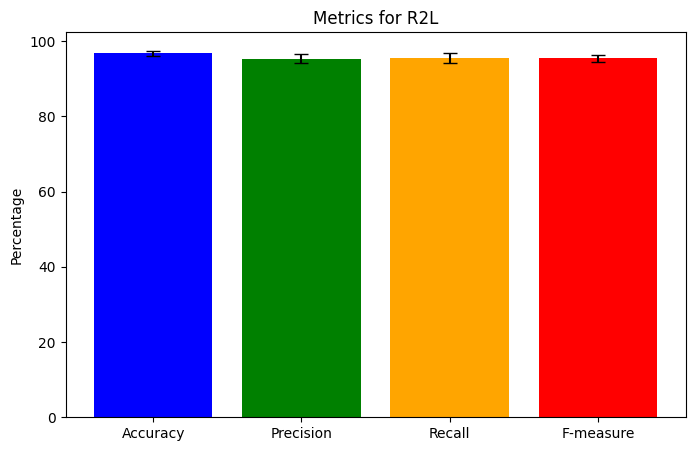

U2R
---------
Accuracy: 99.70341% (+/- 0.28118%)
Precision: 93.14325% (+/- 14.67911%)
Recall: 85.07271% (+/- 17.63892%)
F-measure: 87.83136% (+/- 11.38995%)



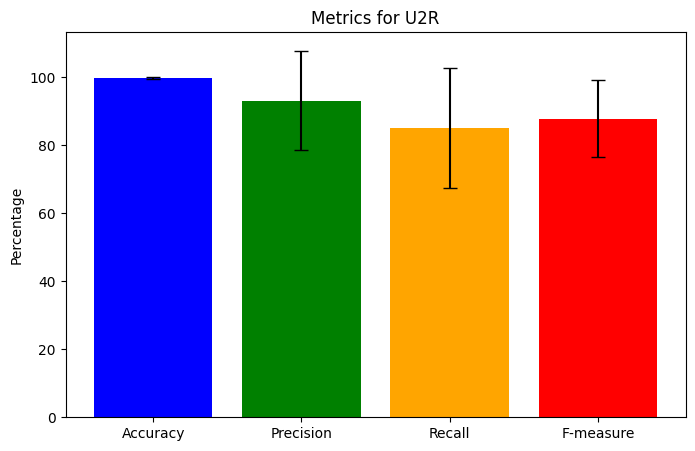

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt

def print_metrics(classifier, X, Y, class_name):
    accuracy = cross_val_score(classifier, X, Y, cv=10, scoring='accuracy')
    precision = cross_val_score(classifier, X, Y, cv=10, scoring='precision_macro')
    recall = cross_val_score(classifier, X, Y, cv=10, scoring='recall_macro')
    f_measure = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')

    print(class_name)
    print('---------')
    print("Accuracy: %0.5f%% (+/- %0.5f%%)" % (accuracy.mean() * 100, accuracy.std() * 200))
    print("Precision: %0.5f%% (+/- %0.5f%%)" % (precision.mean() * 100, precision.std() * 200))
    print("Recall: %0.5f%% (+/- %0.5f%%)" % (recall.mean() * 100, recall.std() * 200))
    print("F-measure: %0.5f%% (+/- %0.5f%%)" % (f_measure.mean() * 100, f_measure.std() * 200))
    print()

    # Plotting
    labels = ['Accuracy', 'Precision', 'Recall', 'F-measure']
    values = [accuracy.mean() * 100, precision.mean() * 100, recall.mean() * 100, f_measure.mean() * 100]
    errors = [accuracy.std() * 200, precision.std() * 200, recall.std() * 200, f_measure.std() * 200]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, yerr=errors, capsize=5, color=['blue', 'green', 'orange', 'red'])
    plt.title(f'Metrics for {class_name}')
    plt.ylabel('Percentage')
    plt.show()

print_metrics(clf_KNN_DoS, X_DoS_test, Y_DoS_test, 'DOS')
print_metrics(clf_KNN_Probe, X_Probe_test, Y_Probe_test, 'Probe')
print_metrics(clf_KNN_R2L, X_R2L_test, Y_R2L_test, 'R2L')
print_metrics(clf_KNN_U2R, X_U2R_test, Y_U2R_test, 'U2R')

# SVM
 for cross validation of all models

In [ ]:

from sklearn.svm import SVC

clf_SVM_DoS=SVC(kernel='linear', C=1.0, random_state=0)
clf_SVM_Probe=SVC(kernel='linear', C=1.0, random_state=0)
clf_SVM_R2L=SVC(kernel='linear', C=1.0, random_state=0)
clf_SVM_U2R=SVC(kernel='linear', C=1.0, random_state=0)

clf_SVM_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_SVM_Probe.fit(X_Probe, Y_Probe.astype(int))
clf_SVM_R2L.fit(X_R2L, Y_R2L.astype(int))
clf_SVM_U2R.fit(X_U2R, Y_U2R.astype(int))


SVC(kernel='linear', random_state=0)

In [ ]:
print('DOS')
print('-----------')
Y_DoS_pred=clf_SVM_DoS.predict(X_DoS_test)

# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

DOS
-----------


Predicted attacks,0,1
Actual attacks,,
0,9455,256
1,1359,6101


In [ ]:
print('Probe')
print('-----------')
Y_Probe_pred=clf_SVM_Probe.predict(X_Probe_test)
# Create confusion matrix

pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Probe
-----------


Predicted attacks,0,2
Actual attacks,,
0,9576,135
2,1285,1136


In [ ]:
print('R2L')
print('-----------')

Y_R2L_pred=clf_SVM_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

R2L
-----------


Predicted attacks,0,3
Actual attacks,,
0,9639,72
3,2737,148


In [ ]:
print('U2R')
print('-----------')
Y_U2R_pred=clf_SVM_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

U2R
-----------


Predicted attacks,0,4
Actual attacks,,
0,9710,1
4,67,0


**Cross Validation: Accuracy, Precision, Recall, F-measure**

DOS
-----------
Accuracy: 99.37102% (+/- 0.37498%)
Precision: 99.34175% (+/- 0.41237%)
Recall: 99.38022% (+/- 0.35154%)
F-measure: 99.36034% (+/- 0.38088%)



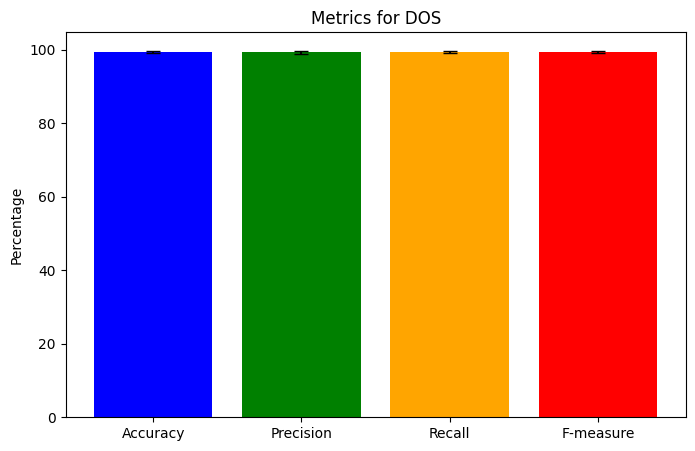

Probe
-----------
Accuracy: 98.45038% (+/- 0.52551%)
Precision: 96.90722% (+/- 1.03132%)
Recall: 98.36543% (+/- 0.68626%)
F-measure: 97.61301% (+/- 0.80023%)



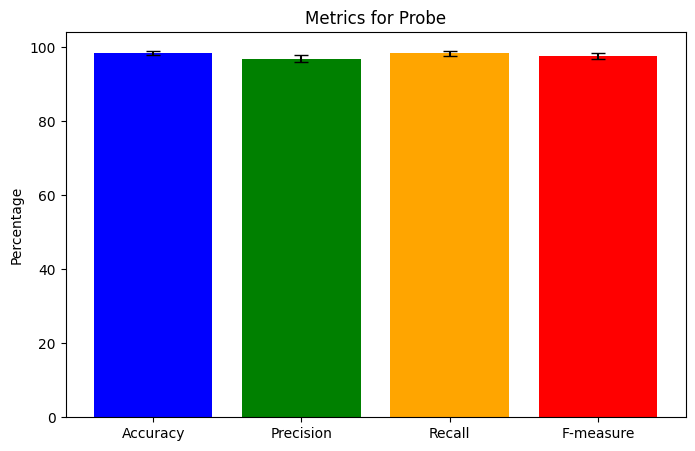

R2L
-----------
Accuracy: 96.79264% (+/- 0.73846%)
Precision: 94.85396% (+/- 0.99350%)
Recall: 96.26352% (+/- 1.38794%)
F-measure: 95.52904% (+/- 1.04836%)



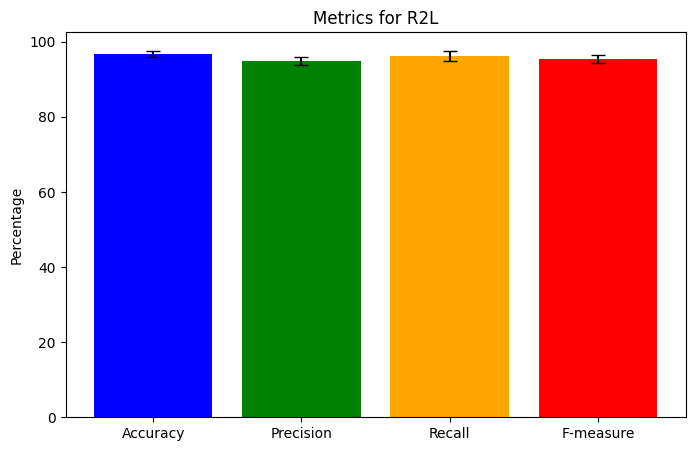

U2R
-----------
Accuracy: 99.63185% (+/- 0.39010%)
Precision: 91.05555% (+/- 17.93427%)
Recall: 82.90926% (+/- 21.83306%)
F-measure: 84.86852% (+/- 16.02890%)



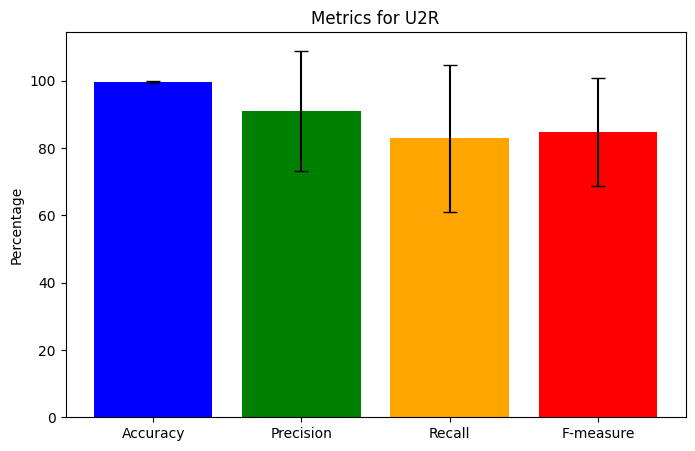

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt

def print_metrics(classifier, X, Y, class_name):
    accuracy = cross_val_score(classifier, X, Y, cv=10, scoring='accuracy')
    precision = cross_val_score(classifier, X, Y, cv=10, scoring='precision_macro')
    recall = cross_val_score(classifier, X, Y, cv=10, scoring='recall_macro')
    f_measure = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')

    print(class_name)
    print('-----------')
    print("Accuracy: %0.5f%% (+/- %0.5f%%)" % (accuracy.mean() * 100, accuracy.std() * 200))
    print("Precision: %0.5f%% (+/- %0.5f%%)" % (precision.mean() * 100, precision.std() * 200))
    print("Recall: %0.5f%% (+/- %0.5f%%)" % (recall.mean() * 100, recall.std() * 200))
    print("F-measure: %0.5f%% (+/- %0.5f%%)" % (f_measure.mean() * 100, f_measure.std() * 200))
    print()

    # Plotting
    labels = ['Accuracy', 'Precision', 'Recall', 'F-measure']
    values = [accuracy.mean() * 100, precision.mean() * 100, recall.mean() * 100, f_measure.mean() * 100]
    errors = [accuracy.std() * 200, precision.std() * 200, recall.std() * 200, f_measure.std() * 200]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, yerr=errors, capsize=5, color=['blue', 'green', 'orange', 'red'])
    plt.title(f'Metrics for {class_name}')
    plt.ylabel('Percentage')
    plt.show()


print_metrics(clf_SVM_DoS, X_DoS_test, Y_DoS_test, 'DOS')
print_metrics(clf_SVM_Probe, X_Probe_test, Y_Probe_test, 'Probe')
print_metrics(clf_SVM_R2L, X_R2L_test, Y_R2L_test, 'R2L')
print_metrics(clf_SVM_U2R, X_U2R_test, Y_U2R_test, 'U2R')


# Ensemble Learning

In [ ]:
from sklearn.ensemble import VotingClassifier

clf_voting_DoS = VotingClassifier(estimators=[ ('knn', clf_KNN_DoS), ('svm', clf_SVM_DoS)], voting='hard')
clf_voting_Probe = VotingClassifier(estimators=[('knn', clf_KNN_Probe), ('svm', clf_SVM_Probe)], voting='hard')
clf_voting_R2L = VotingClassifier(estimators=[ ('knn', clf_KNN_R2L), ('svm', clf_SVM_R2L)], voting='hard')
clf_voting_U2R = VotingClassifier(estimators=[ ('knn', clf_KNN_U2R), ('svm', clf_SVM_U2R)], voting='hard')

clf_voting_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_voting_Probe.fit(X_Probe, Y_Probe.astype(int))
clf_voting_R2L.fit(X_R2L, Y_R2L.astype(int))
clf_voting_U2R.fit(X_U2R, Y_U2R.astype(int))

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('svm', SVC(kernel='linear', random_state=0))])

In [ ]:
print('DOS')
print('-----------')
Y_DoS_pred=clf_voting_DoS.predict(X_DoS_test)

# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


DOS
-----------


Predicted attacks,0,1
Actual attacks,,
0,9607,104
1,1953,5507


In [ ]:
print('Probe')
print('-----------')
Y_Probe_pred=clf_voting_Probe.predict(X_Probe_test)

# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Probe
-----------


Predicted attacks,0,2
Actual attacks,,
0,9634,77
2,1581,840


In [ ]:
print('R2L')
print('-----------')
Y_R2L_pred=clf_voting_R2L.predict(X_R2L_test)

# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

R2L
-----------


Predicted attacks,0,3
Actual attacks,,
0,9711,0
3,2884,1


In [ ]:
print('U2R')
print('-----------')
Y_U2R_pred=clf_voting_U2R.predict(X_U2R_test)

# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

U2R
-----------


Predicted attacks,0
Actual attacks,
0,9711
4,67


DOS
-----------
Accuracy: 99.66222% (+/- 0.23760%)
Precision: 99.68825% (+/- 0.23356%)
Recall: 99.62524% (+/- 0.25195%)
F-measure: 99.65608% (+/- 0.24195%)



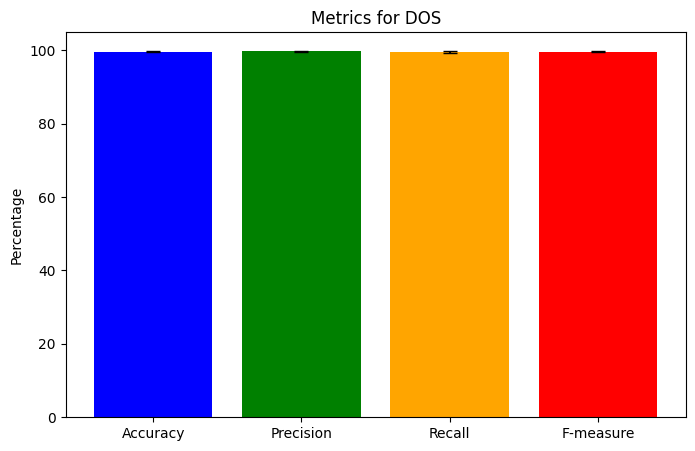

Probe
-----------
Accuracy: 98.96965% (+/- 0.39892%)
Precision: 98.59196% (+/- 0.67255%)
Recall: 98.17798% (+/- 1.04525%)
F-measure: 98.37969% (+/- 0.63986%)



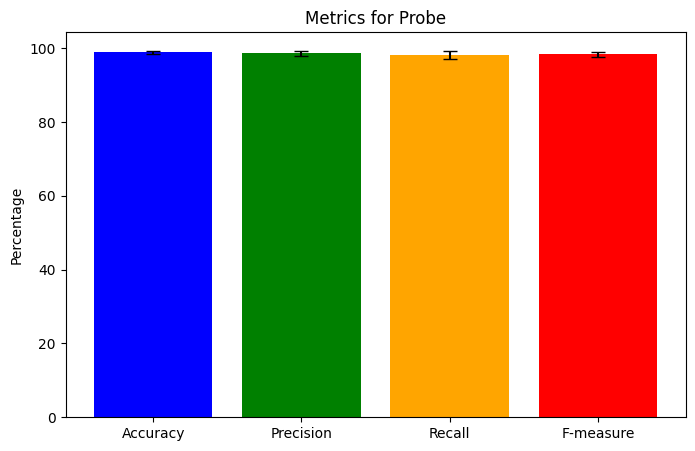

R2L
-----------
Accuracy: 96.55448% (+/- 0.82229%)
Precision: 95.58714% (+/- 0.98276%)
Recall: 94.58607% (+/- 1.90257%)
F-measure: 95.06447% (+/- 1.23041%)



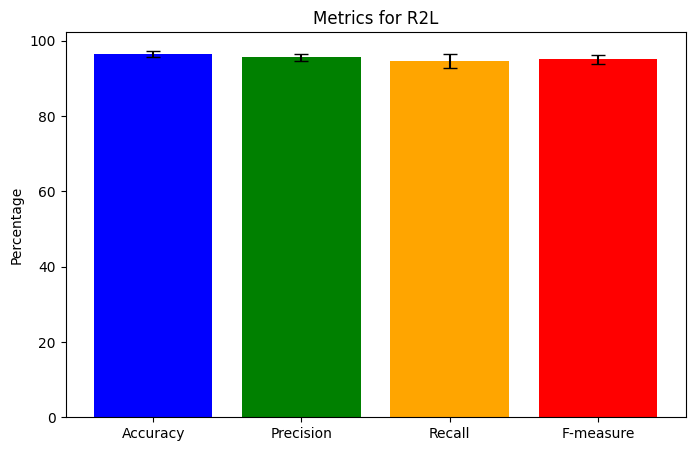

U2R
-----------
Accuracy: 99.62161% (+/- 0.35477%)
Precision: 92.70313% (+/- 15.64309%)
Recall: 77.82110% (+/- 19.67592%)
F-measure: 82.66023% (+/- 17.13997%)



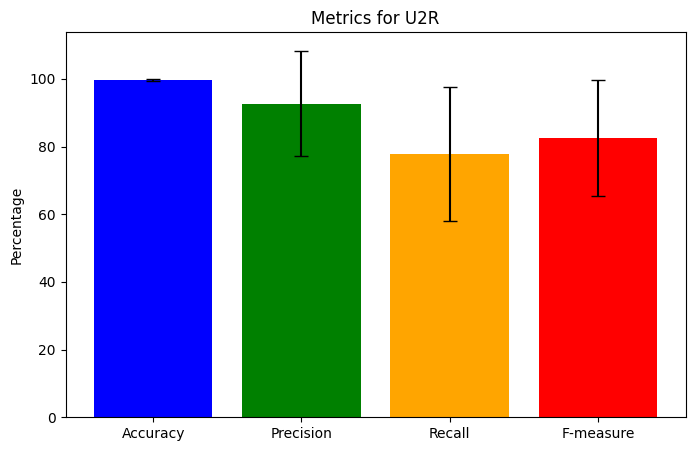

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt

def print_metrics(classifier, X, Y, class_name):
    accuracy = cross_val_score(classifier, X, Y, cv=10, scoring='accuracy')
    precision = cross_val_score(classifier, X, Y, cv=10, scoring='precision_macro')
    recall = cross_val_score(classifier, X, Y, cv=10, scoring='recall_macro')
    f_measure = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')

    print(class_name)
    print('-----------')
    print("Accuracy: %0.5f%% (+/- %0.5f%%)" % (accuracy.mean() * 100, accuracy.std() * 200))
    print("Precision: %0.5f%% (+/- %0.5f%%)" % (precision.mean() * 100, precision.std() * 200))
    print("Recall: %0.5f%% (+/- %0.5f%%)" % (recall.mean() * 100, recall.std() * 200))
    print("F-measure: %0.5f%% (+/- %0.5f%%)" % (f_measure.mean() * 100, f_measure.std() * 200))
    print()

    # Plotting
    labels = ['Accuracy', 'Precision', 'Recall', 'F-measure']
    values = [accuracy.mean() * 100, precision.mean() * 100, recall.mean() * 100, f_measure.mean() * 100]
    errors = [accuracy.std() * 200, precision.std() * 200, recall.std() * 200, f_measure.std() * 200]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, yerr=errors, capsize=5, color=['blue', 'green', 'orange', 'red'])
    plt.title(f'Metrics for {class_name}')
    plt.ylabel('Percentage')
    plt.show()

print_metrics(clf_voting_DoS, X_DoS_test, Y_DoS_test, 'DOS')
print_metrics(clf_voting_Probe, X_Probe_test, Y_Probe_test, 'Probe')
print_metrics(clf_voting_R2L, X_R2L_test, Y_R2L_test, 'R2L')
print_metrics(clf_voting_U2R, X_U2R_test, Y_U2R_test, 'U2R')


# Naive bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf_NB_DoS = GaussianNB()
clf_NB_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_NB_Probe = GaussianNB()
clf_NB_Probe.fit(X_Probe, Y_Probe.astype(int))
clf_NB_R2L = GaussianNB()
clf_NB_R2L.fit(X_R2L, Y_R2L.astype(int))
clf_NB_U2R = GaussianNB()
clf_NB_U2R.fit(X_U2R, Y_U2R.astype(int))


GaussianNB()

In [ ]:
print('DOS')
print('-----------')

Y_DoS_pred=clf_NB_DoS.predict(X_DoS_test)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


DOS
-----------


Predicted attacks,0,1
Actual attacks,,
0,9447,264
1,3701,3759


In [ ]:
print('Probe')
print('-----------')
Y_Probe_pred=clf_NB_Probe.predict(X_Probe_test)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Probe
-----------


Predicted attacks,0,2
Actual attacks,,
0,76,9635
2,201,2220


In [ ]:
print('R2L')
print('-----------')
Y_R2L_pred=clf_NB_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


R2L
-----------


Predicted attacks,0
Actual attacks,
0,9711
3,2885


In [ ]:
print('U2R')
print('-----------')
Y_U2R_pred=clf_NB_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


U2R
-----------


Predicted attacks,0
Actual attacks,
0,9711
4,67


DOS
-----------
Accuracy: 94.27468% (+/- 1.12691%)
Precision: 95.46186% (+/- 0.80885%)
Recall: 93.11327% (+/- 1.36820%)
F-measure: 93.95605% (+/- 1.22049%)



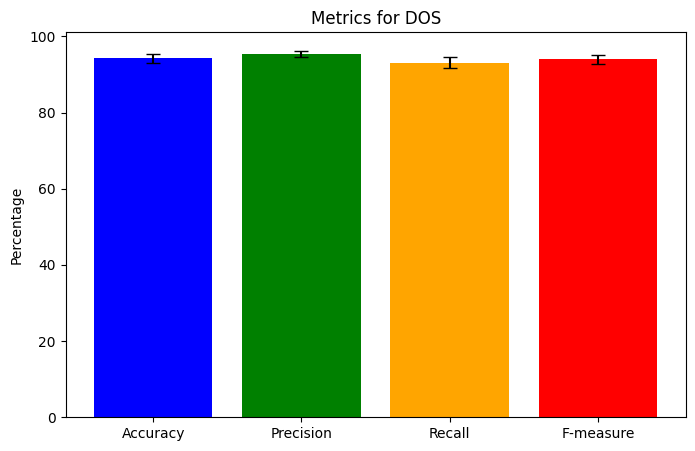

Probe
-----------
Accuracy: 88.69620% (+/- 0.92535%)
Precision: 91.97171% (+/- 3.25214%)
Recall: 62.44309% (+/- 2.68284%)
F-measure: 66.72476% (+/- 3.67110%)



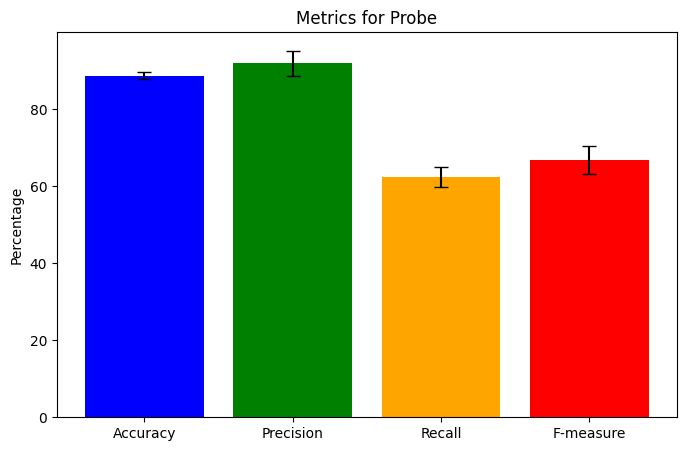

R2L
-----------
Accuracy: 61.12747% (+/- 20.06613%)
Precision: 52.19834% (+/- 2.94676%)
Recall: 79.55180% (+/- 7.76230%)
F-measure: 41.64319% (+/- 11.82486%)



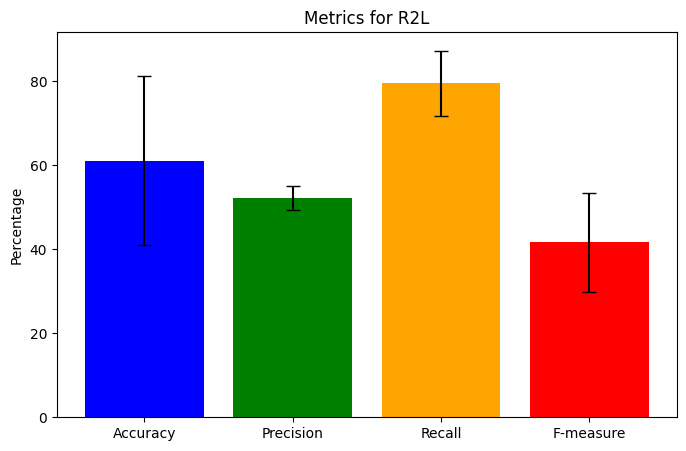

U2R
-----------
Accuracy: 94.76966% (+/- 1.27817%)
Precision: 50.76790% (+/- 0.81313%)
Recall: 87.39328% (+/- 32.97281%)
F-measure: 50.17987% (+/- 1.65470%)



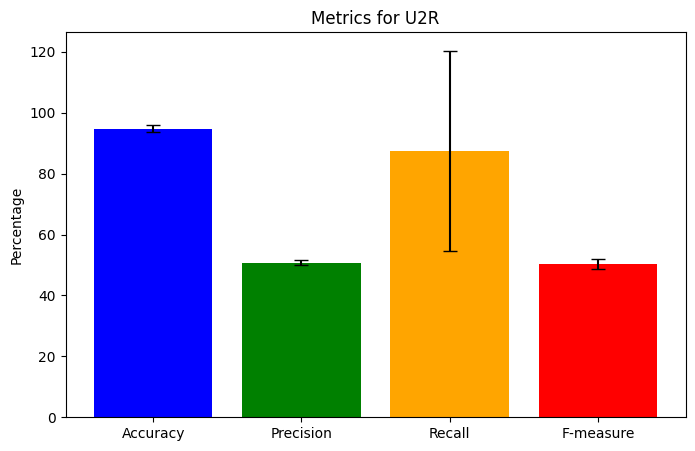

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt

def print_metrics_gaussian_naive_bayes(classifier, X, Y, class_name):
    accuracy = cross_val_score(classifier, X, Y, cv=10, scoring='accuracy')
    precision = cross_val_score(classifier, X, Y, cv=10, scoring='precision_macro')
    recall = cross_val_score(classifier, X, Y, cv=10, scoring='recall_macro')
    f_measure = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')

    print(class_name)
    print('-----------')
    print("Accuracy: %0.5f%% (+/- %0.5f%%)" % (accuracy.mean() * 100, accuracy.std() * 200))
    print("Precision: %0.5f%% (+/- %0.5f%%)" % (precision.mean() * 100, precision.std() * 200))
    print("Recall: %0.5f%% (+/- %0.5f%%)" % (recall.mean() * 100, recall.std() * 200))
    print("F-measure: %0.5f%% (+/- %0.5f%%)" % (f_measure.mean() * 100, f_measure.std() * 200))
    print()

    # Plotting
    labels = ['Accuracy', 'Precision', 'Recall', 'F-measure']
    values = [accuracy.mean() * 100, precision.mean() * 100, recall.mean() * 100, f_measure.mean() * 100]
    errors = [accuracy.std() * 200, precision.std() * 200, recall.std() * 200, f_measure.std() * 200]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, yerr=errors, capsize=5, color=['blue', 'green', 'orange', 'red'])
    plt.title(f'Metrics for {class_name}')
    plt.ylabel('Percentage')
    plt.show()

# Split the data into training and testing sets
X_DoS_train, X_DoS_test, Y_DoS_train, Y_DoS_test = train_test_split(X_DoS, Y_DoS, test_size=0.2, random_state=42)
X_Probe_train, X_Probe_test, Y_Probe_train, Y_Probe_test = train_test_split(X_Probe, Y_Probe, test_size=0.2, random_state=42)
X_R2L_train, X_R2L_test, Y_R2L_train, Y_R2L_test = train_test_split(X_R2L, Y_R2L, test_size=0.2, random_state=42)
X_U2R_train, X_U2R_test, Y_U2R_train, Y_U2R_test = train_test_split(X_U2R, Y_U2R, test_size=0.2, random_state=42)

# Create Gaussian Naive Bayes classifiers
GNB_Classifier_DoS = GaussianNB()
GNB_Classifier_Probe = GaussianNB()
GNB_Classifier_R2L = GaussianNB()
GNB_Classifier_U2R = GaussianNB()

# Train the classifiers
GNB_Classifier_DoS.fit(X_DoS_train, Y_DoS_train)
GNB_Classifier_Probe.fit(X_Probe_train, Y_Probe_train)
GNB_Classifier_R2L.fit(X_R2L_train, Y_R2L_train)
GNB_Classifier_U2R.fit(X_U2R_train, Y_U2R_train)

# Print and plot metrics
print_metrics_gaussian_naive_bayes(GNB_Classifier_DoS, X_DoS_test, Y_DoS_test, 'DOS')
print_metrics_gaussian_naive_bayes(GNB_Classifier_Probe, X_Probe_test, Y_Probe_test, 'Probe')
print_metrics_gaussian_naive_bayes(GNB_Classifier_R2L, X_R2L_test, Y_R2L_test, 'R2L')
print_metrics_gaussian_naive_bayes(GNB_Classifier_U2R, X_U2R_test, Y_U2R_test, 'U2R')



# Dimensionality reduction : PCA

In [ ]:

from sklearn.decomposition import PCA
pca = PCA()
X_DoS_pca = pca.fit_transform(X_DoS)
X_Probe_pca = pca.fit_transform(X_Probe)
X_R2L_pca = pca.fit_transform(X_R2L)
X_U2R_pca = pca.fit_transform(X_U2R)


In [ ]:
GNB_Classifier_DoS.fit(X_DoS_pca, Y_DoS)
Y_DoS_pred=GNB_Classifier_DoS.predict(X_DoS_pca)
print('DOS')
print('-----------')
# Create confusion matrix
pd.crosstab(Y_DoS, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


DOS
-----------


Predicted attacks,0,1
Actual attacks,,
0,66827,516
1,25305,20622


In [ ]:
GNB_Classifier_Probe.fit(X_Probe_pca, Y_Probe)
Y_Probe_pred=GNB_Classifier_Probe.predict(X_Probe_pca)
print('Probe')
print('-----------')
# Create confusion matrix
pd.crosstab(Y_Probe, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Probe
-----------


Predicted attacks,0,2
Actual attacks,,
0,65709,1634
2,10229,1427


In [ ]:
GNB_Classifier_R2L.fit(X_R2L_pca, Y_R2L)
Y_R2L_pred=GNB_Classifier_R2L.predict(X_R2L_pca)
print('R2L')
print('-----------')
# Create confusion matrix
pd.crosstab(Y_R2L, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])




R2L
-----------


Predicted attacks,0,3
Actual attacks,,
0,63559,3784
3,499,496


In [ ]:
GNB_Classifier_U2R.fit(X_U2R_pca, Y_U2R)
Y_U2R_pred=GNB_Classifier_U2R.predict(X_U2R_pca)
print('U2R')
print('-----------')
# Create confusion matrix
pd.crosstab(Y_U2R, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


U2R
-----------


Predicted attacks,0,4
Actual attacks,,
0,64948,2395
4,12,40


DOS
-----------
Accuracy: 76.84292% (+/- 0.78740%)
Precision: 83.04903% (+/- 0.68483%)
Recall: 72.42720% (+/- 0.98240%)
F-measure: 72.94226% (+/- 1.15045%)



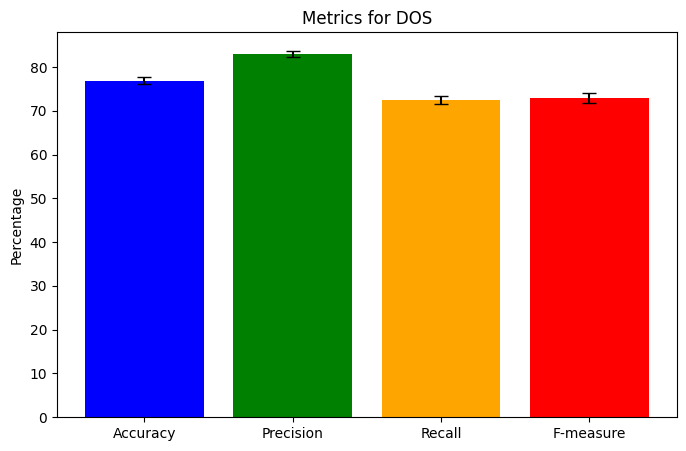

Probe
-----------
Accuracy: 83.65190% (+/- 3.10787%)
Precision: 62.54290% (+/- 10.26107%)
Recall: 57.71984% (+/- 15.30316%)
F-measure: 58.14052% (+/- 13.34646%)



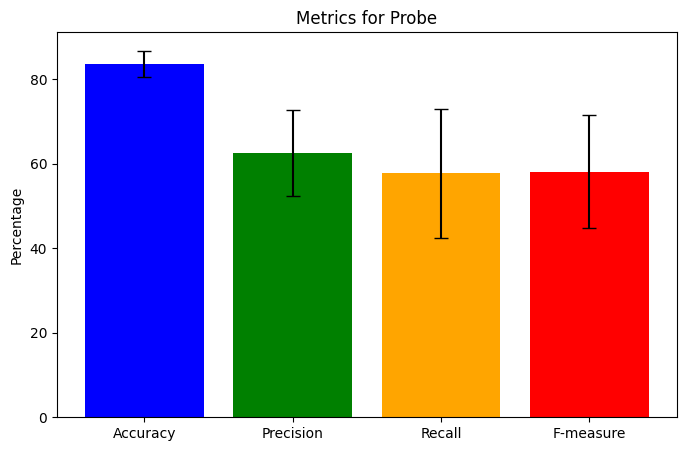

R2L
-----------
Accuracy: 95.58091% (+/- 0.56779%)
Precision: 58.57630% (+/- 3.07735%)
Recall: 75.39151% (+/- 13.32382%)
F-measure: 62.28406% (+/- 4.80199%)



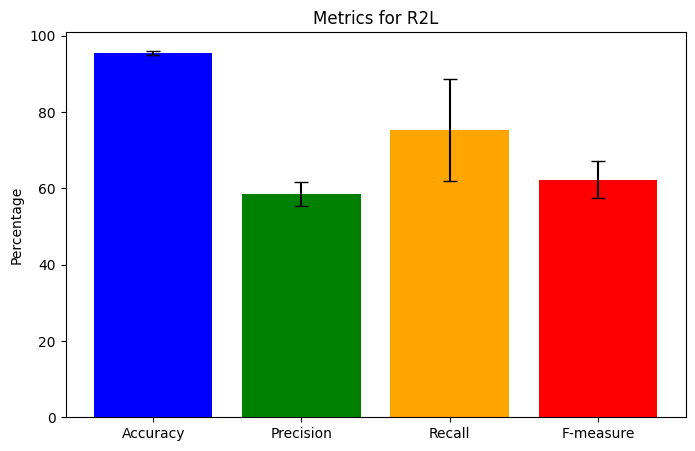

U2R
-----------
Accuracy: 96.81727% (+/- 1.48143%)
Precision: 50.87441% (+/- 1.33505%)
Recall: 80.92924% (+/- 44.91485%)
F-measure: 50.93460% (+/- 2.48376%)



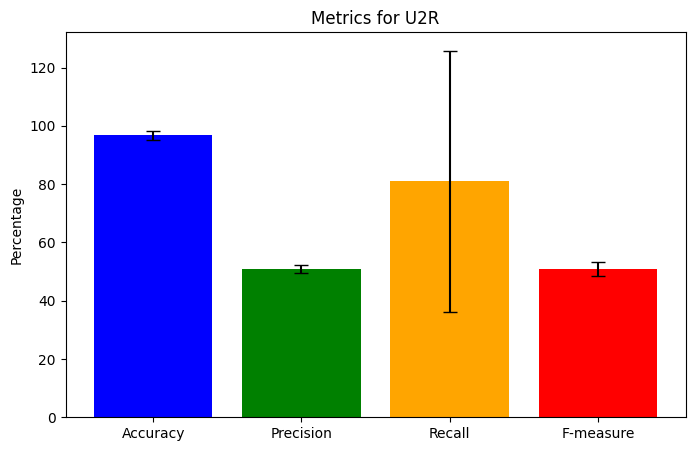

In [ ]:
from sklearn.decomposition import PCA

# Function to perform PCA
def apply_pca(X_train, X_test):
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca


# Split the data into training and testing sets
X_DoS_train, X_DoS_test, Y_DoS_train, Y_DoS_test = train_test_split(X_DoS, Y_DoS, test_size=0.2, random_state=42)
X_Probe_train, X_Probe_test, Y_Probe_train, Y_Probe_test = train_test_split(X_Probe, Y_Probe, test_size=0.2, random_state=42)
X_R2L_train, X_R2L_test, Y_R2L_train, Y_R2L_test = train_test_split(X_R2L, Y_R2L, test_size=0.2, random_state=42)
X_U2R_train, X_U2R_test, Y_U2R_train, Y_U2R_test = train_test_split(X_U2R, Y_U2R, test_size=0.2, random_state=42)

# Apply PCA
X_DoS_train_pca, X_DoS_test_pca = apply_pca(X_DoS_train, X_DoS_test)
X_Probe_train_pca, X_Probe_test_pca = apply_pca(X_Probe_train, X_Probe_test)
X_R2L_train_pca, X_R2L_test_pca = apply_pca(X_R2L_train, X_R2L_test)
X_U2R_train_pca, X_U2R_test_pca = apply_pca(X_U2R_train, X_U2R_test)

# Create Gaussian Naive Bayes classifiers
GNB_Classifier_DoS = GaussianNB()
GNB_Classifier_Probe = GaussianNB()
GNB_Classifier_R2L = GaussianNB()
GNB_Classifier_U2R = GaussianNB()

# Train the classifiers
GNB_Classifier_DoS.fit(X_DoS_train_pca, Y_DoS_train)
GNB_Classifier_Probe.fit(X_Probe_train_pca, Y_Probe_train)
GNB_Classifier_R2L.fit(X_R2L_train_pca, Y_R2L_train)
GNB_Classifier_U2R.fit(X_U2R_train_pca, Y_U2R_train)

# Print and plot metrics
print_metrics_gaussian_naive_bayes(GNB_Classifier_DoS, X_DoS_test_pca, Y_DoS_test, 'DOS')
print_metrics_gaussian_naive_bayes(GNB_Classifier_Probe, X_Probe_test_pca, Y_Probe_test, 'Probe')
print_metrics_gaussian_naive_bayes(GNB_Classifier_R2L, X_R2L_test_pca, Y_R2L_test, 'R2L')
print_metrics_gaussian_naive_bayes(GNB_Classifier_U2R, X_U2R_test_pca, Y_U2R_test, 'U2R')

DOS
-----------
Accuracy: 88.06408% (+/- 5.81618%)
Precision: 87.82685% (+/- 5.27003%)
Recall: 88.56410% (+/- 4.75541%)
F-measure: 87.88036% (+/- 5.69477%)



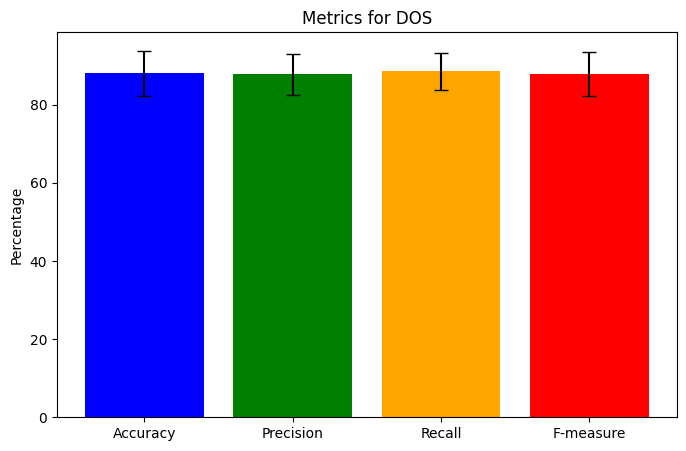

Probe
-----------
Accuracy: 93.64557% (+/- 1.03023%)
Precision: 86.52400% (+/- 2.34031%)
Recall: 89.71181% (+/- 1.96291%)
F-measure: 87.98717% (+/- 1.76120%)



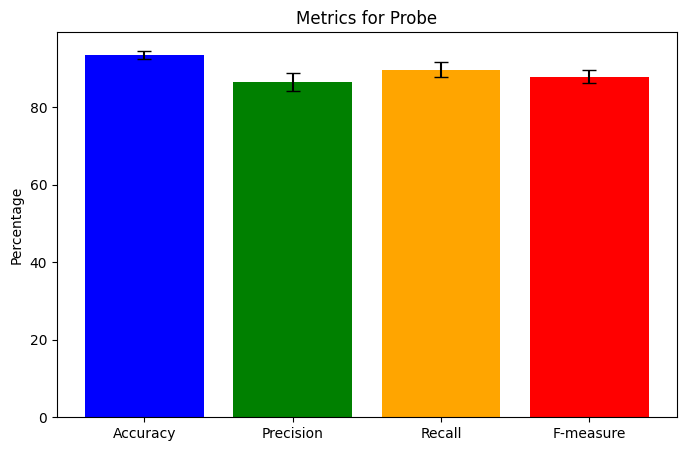

R2L
-----------
Accuracy: 94.98823% (+/- 0.85787%)
Precision: 55.38160% (+/- 2.44285%)
Recall: 65.65217% (+/- 6.04498%)
F-measure: 57.53316% (+/- 3.51135%)



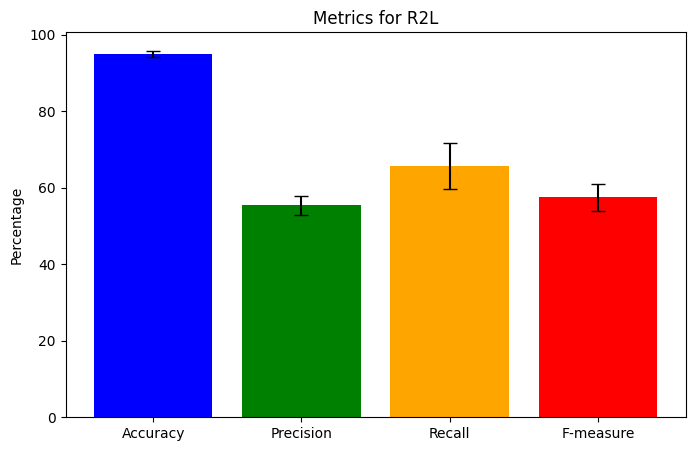

U2R
-----------
Accuracy: 98.56815% (+/- 1.11431%)
Precision: 51.74512% (+/- 3.51841%)
Recall: 74.30932% (+/- 44.65020%)
F-measure: 52.92605% (+/- 6.41788%)



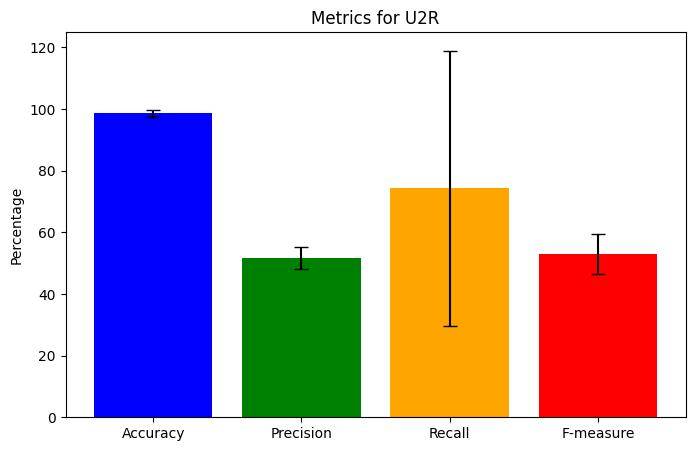

In [ ]:
from sklearn.decomposition import PCA

# Function to perform PCA
def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

# Split the data into training and testing sets
X_DoS_train, X_DoS_test, Y_DoS_train, Y_DoS_test = train_test_split(X_DoS, Y_DoS, test_size=0.2, random_state=42)
X_Probe_train, X_Probe_test, Y_Probe_train, Y_Probe_test = train_test_split(X_Probe, Y_Probe, test_size=0.2, random_state=42)
X_R2L_train, X_R2L_test, Y_R2L_train, Y_R2L_test = train_test_split(X_R2L, Y_R2L, test_size=0.2, random_state=42)
X_U2R_train, X_U2R_test, Y_U2R_train, Y_U2R_test = train_test_split(X_U2R, Y_U2R, test_size=0.2, random_state=42)

# Apply PCA
n_components = 13
X_DoS_train_pca, X_DoS_test_pca = apply_pca(X_DoS_train, X_DoS_test, n_components)
X_Probe_train_pca, X_Probe_test_pca = apply_pca(X_Probe_train, X_Probe_test, n_components)
X_R2L_train_pca, X_R2L_test_pca = apply_pca(X_R2L_train, X_R2L_test, n_components)
X_U2R_train_pca, X_U2R_test_pca = apply_pca(X_U2R_train, X_U2R_test, n_components)

# Create Gaussian Naive Bayes classifiers
GNB_Classifier_DoS = GaussianNB()
GNB_Classifier_Probe = GaussianNB()
GNB_Classifier_R2L = GaussianNB()
GNB_Classifier_U2R = GaussianNB()

# Train the classifiers
GNB_Classifier_DoS.fit(X_DoS_train_pca, Y_DoS_train)
GNB_Classifier_Probe.fit(X_Probe_train_pca, Y_Probe_train)
GNB_Classifier_R2L.fit(X_R2L_train_pca, Y_R2L_train)
GNB_Classifier_U2R.fit(X_U2R_train_pca, Y_U2R_train)

# Print and plot metrics
print_metrics_gaussian_naive_bayes(GNB_Classifier_DoS, X_DoS_test_pca, Y_DoS_test, 'DOS')
print_metrics_gaussian_naive_bayes(GNB_Classifier_Probe, X_Probe_test_pca, Y_Probe_test, 'Probe')
print_metrics_gaussian_naive_bayes(GNB_Classifier_R2L, X_R2L_test_pca, Y_R2L_test, 'R2L')
print_metrics_gaussian_naive_bayes(GNB_Classifier_U2R, X_U2R_test_pca, Y_U2R_test, 'U2R')


# Comparing models to SVM

**KNN to SVM**

SVM Metrics:
DOS
---------------
Accuracy: 99.35938% (+/- 0.36839%)
Precision: 99.31975% (+/- 0.39884%)
Recall: 99.37924% (+/- 0.34920%)
F-measure: 99.34863% (+/- 0.37411%)



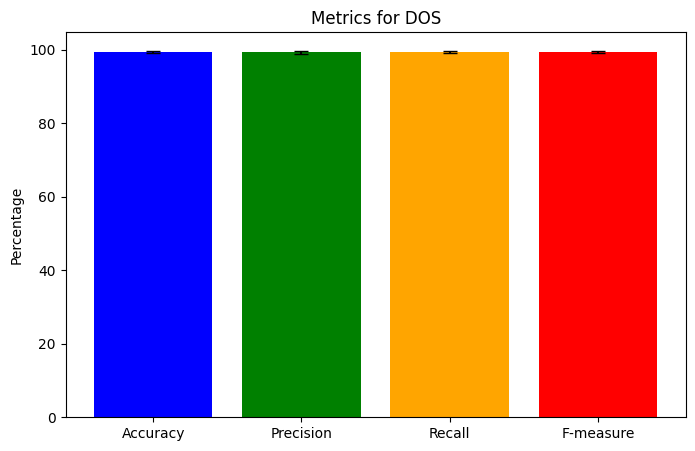

Probe
---------------
Accuracy: 98.59052% (+/- 0.45107%)
Precision: 97.56787% (+/- 0.78239%)
Recall: 98.04990% (+/- 0.80725%)
F-measure: 97.80515% (+/- 0.70362%)



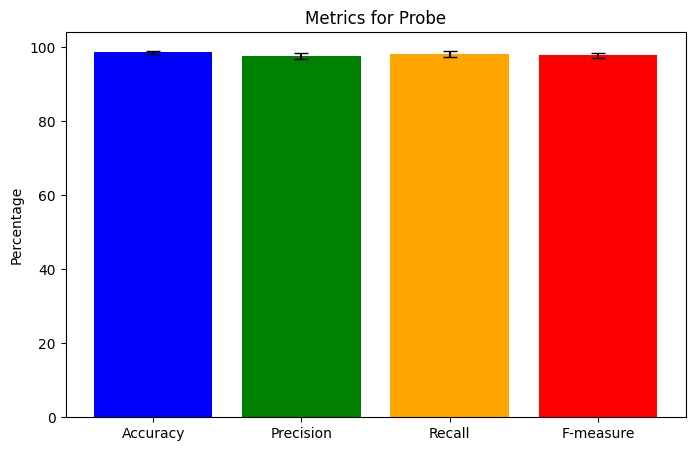

U2R
---------------
Accuracy: 99.55001% (+/- 0.27742%)
Precision: 93.62823% (+/- 17.02473%)
Recall: 70.21750% (+/- 18.83301%)
F-measure: 76.32887% (+/- 18.72380%)



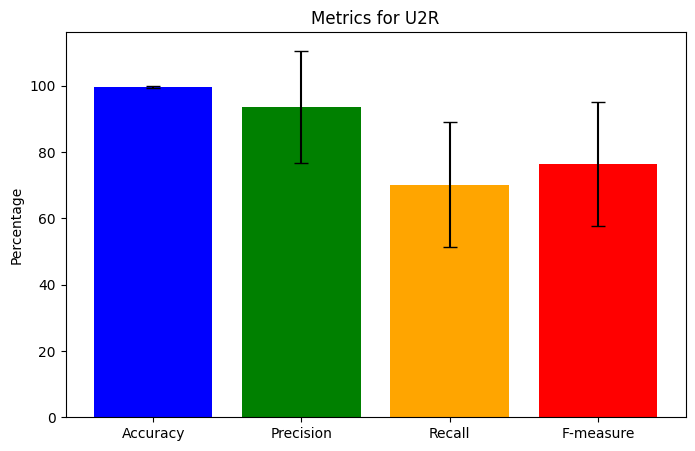

R2L
---------------
Accuracy: 96.74499% (+/- 0.70681%)
Precision: 94.85252% (+/- 1.08913%)
Recall: 96.11031% (+/- 1.24407%)
F-measure: 95.45597% (+/- 0.98503%)



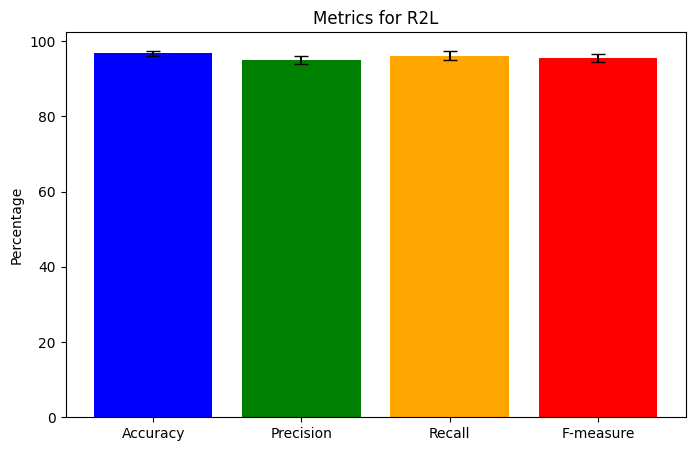


KNN Metrics:
DOS
---------------
Accuracy: 99.71463% (+/- 0.27787%)
Precision: 99.71054% (+/- 0.28611%)
Recall: 99.70886% (+/- 0.28089%)
F-measure: 99.70964% (+/- 0.28271%)



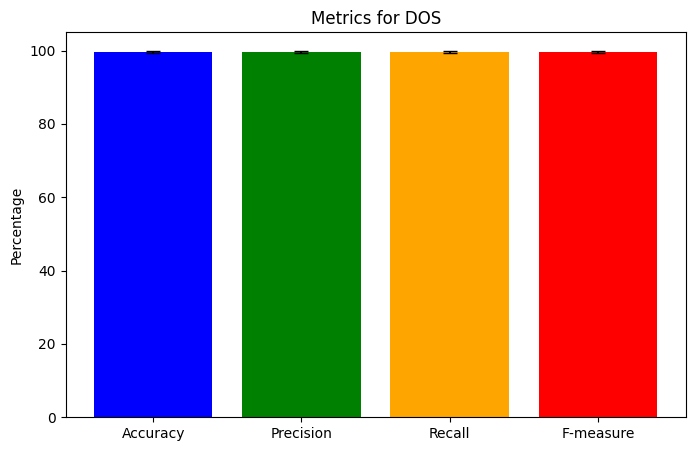

Probe
---------------
Accuracy: 99.07681% (+/- 0.40266%)
Precision: 98.60594% (+/- 0.67516%)
Recall: 98.50846% (+/- 1.13667%)
F-measure: 98.55258% (+/- 0.64466%)



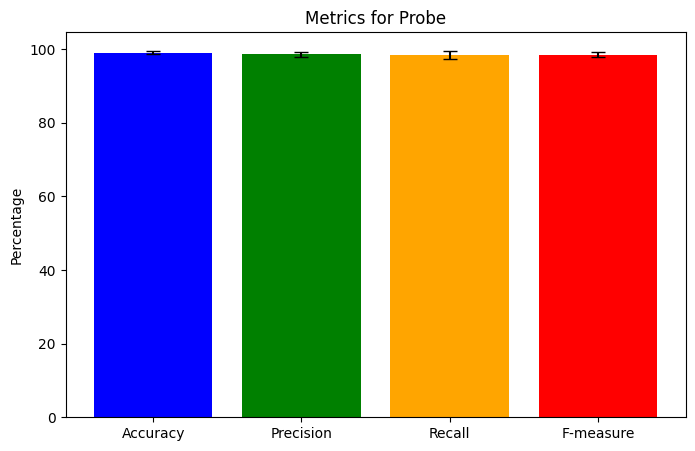

U2R
---------------
Accuracy: 99.70341% (+/- 0.28118%)
Precision: 93.14325% (+/- 14.67911%)
Recall: 85.07271% (+/- 17.63892%)
F-measure: 87.83136% (+/- 11.38995%)



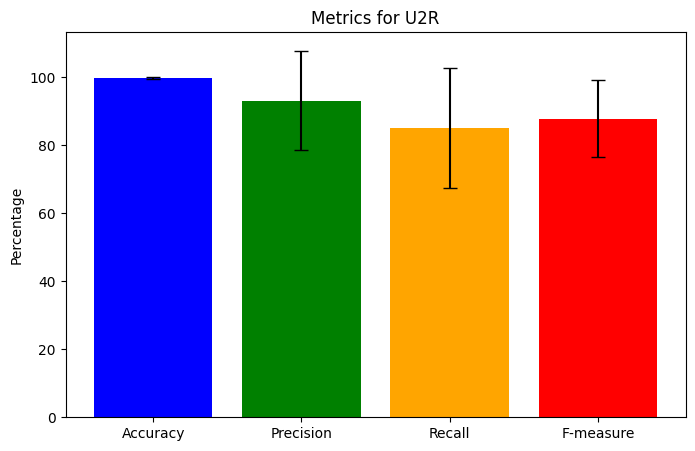

R2L
---------------
Accuracy: 96.74500% (+/- 0.73459%)
Precision: 95.32528% (+/- 1.24687%)
Recall: 95.48918% (+/- 1.32406%)
F-measure: 95.40003% (+/- 1.03913%)



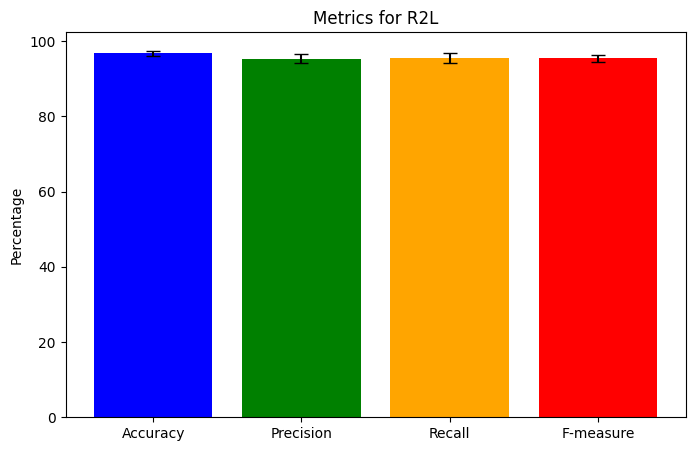

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Create SVM and KNN classifiers
clf_SVM = SVC()
clf_KNN = KNeighborsClassifier()

def print_metrics(classifier, X, Y, class_name):
    accuracy = cross_val_score(classifier, X, Y, cv=10, scoring='accuracy')
    precision = cross_val_score(classifier, X, Y, cv=10, scoring='precision_macro')
    recall = cross_val_score(classifier, X, Y, cv=10, scoring='recall_macro')
    f_measure = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')

    print(class_name)
    print('---------------')
    print("Accuracy: %0.5f%% (+/- %0.5f%%)" % (accuracy.mean() * 100, accuracy.std() * 200))
    print("Precision: %0.5f%% (+/- %0.5f%%)" % (precision.mean() * 100, precision.std() * 200))
    print("Recall: %0.5f%% (+/- %0.5f%%)" % (recall.mean() * 100, recall.std() * 200))
    print("F-measure: %0.5f%% (+/- %0.5f%%)" % (f_measure.mean() * 100, f_measure.std() * 200))
    print()

    # Plotting
    labels = ['Accuracy', 'Precision', 'Recall', 'F-measure']
    values = [accuracy.mean() * 100, precision.mean() * 100, recall.mean() * 100, f_measure.mean() * 100]
    errors = [accuracy.std() * 200, precision.std() * 200, recall.std() * 200, f_measure.std() * 200]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, yerr=errors, capsize=5, color=['blue', 'green', 'orange', 'red'])
    plt.title(f'Metrics for {class_name}')
    plt.ylabel('Percentage')
    plt.show()

# Assuming X_DoS_test, Y_DoS_test, etc. are already defined
print("SVM Metrics:")
print_metrics(clf_SVM, X_DoS_test, Y_DoS_test, 'DOS')
print_metrics(clf_SVM, X_Probe_test, Y_Probe_test, 'Probe')
print_metrics(clf_SVM, X_U2R_test, Y_U2R_test, 'U2R')
print_metrics(clf_SVM, X_R2L_test, Y_R2L_test, 'R2L')

print("\nKNN Metrics:")
print_metrics(clf_KNN, X_DoS_test, Y_DoS_test, 'DOS')
print_metrics(clf_KNN, X_Probe_test, Y_Probe_test, 'Probe')
print_metrics(clf_KNN, X_U2R_test, Y_U2R_test, 'U2R')
print_metrics(clf_KNN, X_R2L_test, Y_R2L_test, 'R2L')


****

**Ensemble Learning to SVM**

SVM Metrics:
DOS
---------------
Accuracy: 99.35938% (+/- 0.36839%)
Precision: 99.31975% (+/- 0.39884%)
Recall: 99.37924% (+/- 0.34920%)
F-measure: 99.34863% (+/- 0.37411%)



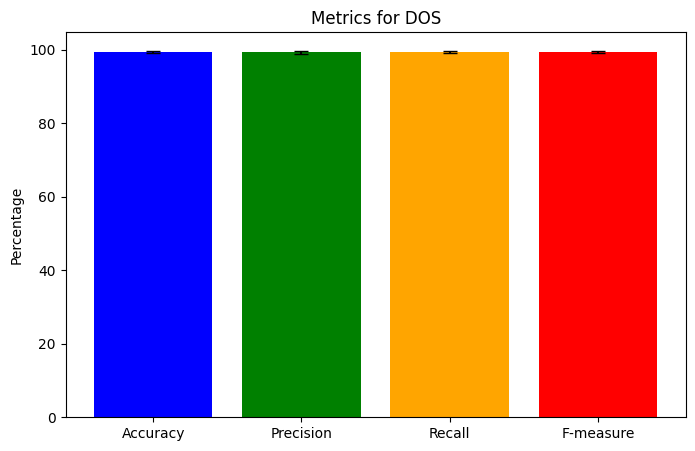

Probe
---------------
Accuracy: 98.59052% (+/- 0.45107%)
Precision: 97.56787% (+/- 0.78239%)
Recall: 98.04990% (+/- 0.80725%)
F-measure: 97.80515% (+/- 0.70362%)



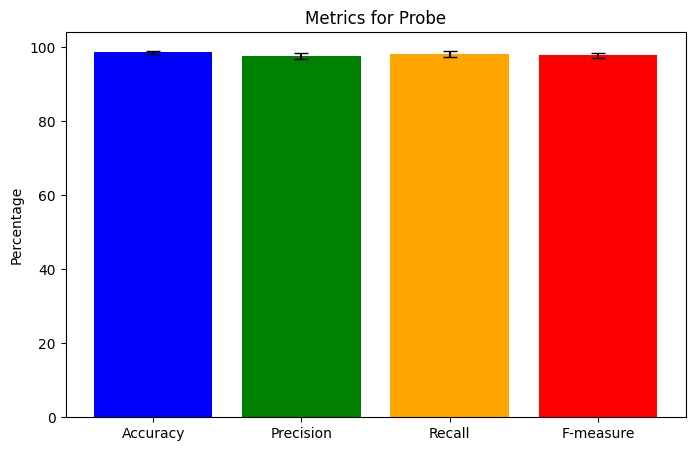

U2R
---------------
Accuracy: 99.55001% (+/- 0.27742%)
Precision: 93.62823% (+/- 17.02473%)
Recall: 70.21750% (+/- 18.83301%)
F-measure: 76.32887% (+/- 18.72380%)



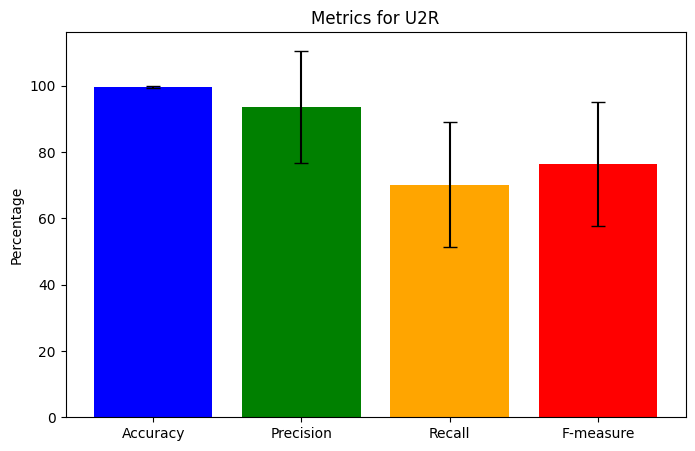

R2L
---------------
Accuracy: 96.74499% (+/- 0.70681%)
Precision: 94.85252% (+/- 1.08913%)
Recall: 96.11031% (+/- 1.24407%)
F-measure: 95.45597% (+/- 0.98503%)



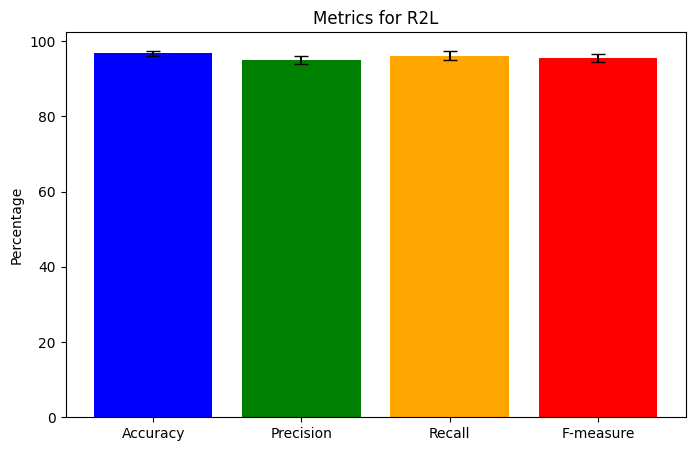


Ensemble Metrics:
DOS
---------------
Accuracy: 99.35938% (+/- 0.36839%)
Precision: 99.31975% (+/- 0.39884%)
Recall: 99.37924% (+/- 0.34920%)
F-measure: 99.34863% (+/- 0.37411%)



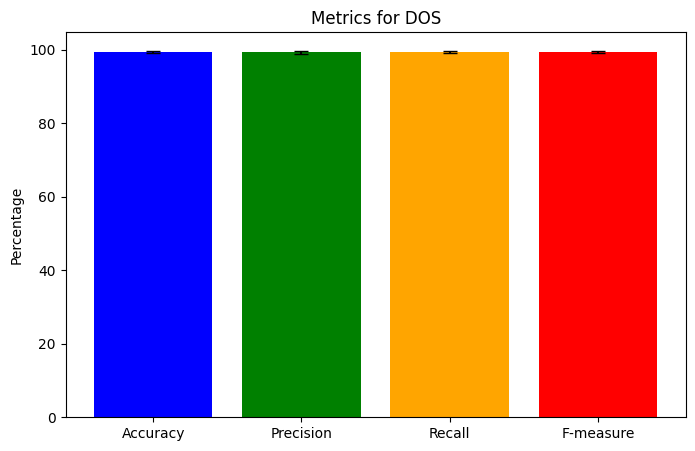

Probe
---------------
Accuracy: 98.59052% (+/- 0.45107%)
Precision: 97.56787% (+/- 0.78239%)
Recall: 98.04990% (+/- 0.80725%)
F-measure: 97.80515% (+/- 0.70362%)



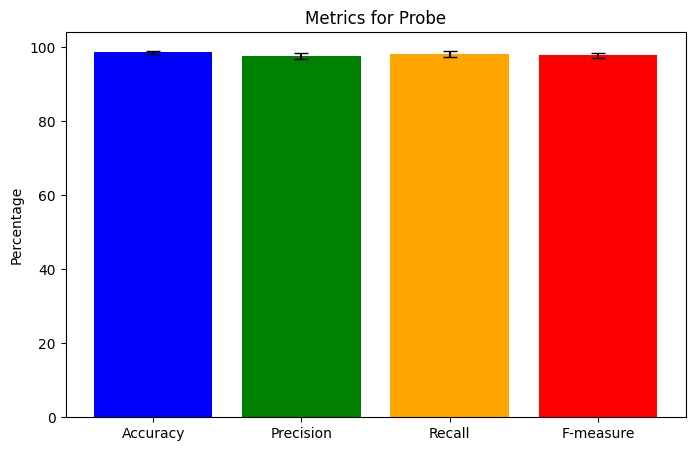

U2R
---------------
Accuracy: 99.55001% (+/- 0.27742%)
Precision: 93.62823% (+/- 17.02473%)
Recall: 70.21750% (+/- 18.83301%)
F-measure: 76.32887% (+/- 18.72380%)



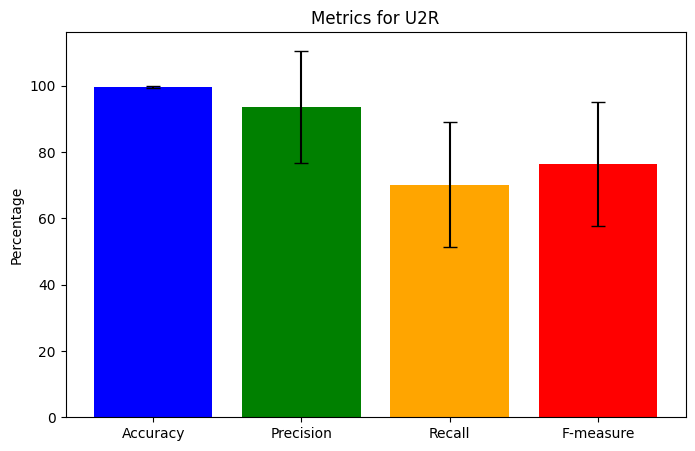

R2L
---------------
Accuracy: 96.74499% (+/- 0.70681%)
Precision: 94.85252% (+/- 1.08913%)
Recall: 96.11031% (+/- 1.24407%)
F-measure: 95.45597% (+/- 0.98503%)



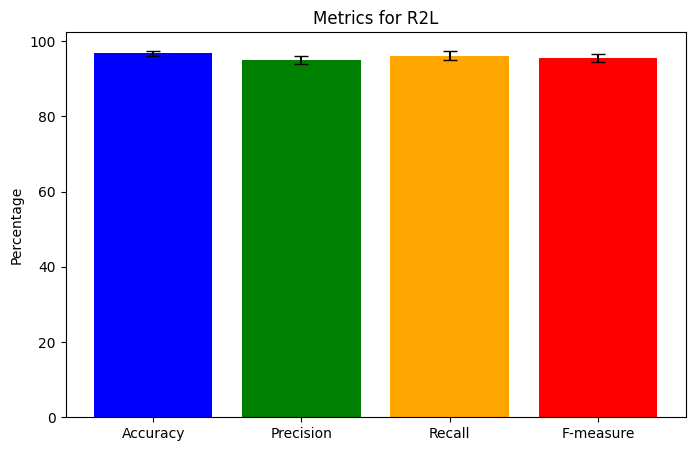

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt

# Create SVM and Naive Bayes classifiers
clf_SVM = SVC()
clf_Ensemble = VotingClassifier(estimators=[('svm', clf_SVM)], voting='hard')

def print_metrics(classifier, X, Y, class_name):
    accuracy = cross_val_score(classifier, X, Y, cv=10, scoring='accuracy')
    precision = cross_val_score(classifier, X, Y, cv=10, scoring='precision_macro')
    recall = cross_val_score(classifier, X, Y, cv=10, scoring='recall_macro')
    f_measure = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')

    print(class_name)
    print('---------------')
    print("Accuracy: %0.5f%% (+/- %0.5f%%)" % (accuracy.mean() * 100, accuracy.std() * 200))
    print("Precision: %0.5f%% (+/- %0.5f%%)" % (precision.mean() * 100, precision.std() * 200))
    print("Recall: %0.5f%% (+/- %0.5f%%)" % (recall.mean() * 100, recall.std() * 200))
    print("F-measure: %0.5f%% (+/- %0.5f%%)" % (f_measure.mean() * 100, f_measure.std() * 200))
    print()

    # Plotting
    labels = ['Accuracy', 'Precision', 'Recall', 'F-measure']
    values = [accuracy.mean() * 100, precision.mean() * 100, recall.mean() * 100, f_measure.mean() * 100]
    errors = [accuracy.std() * 200, precision.std() * 200, recall.std() * 200, f_measure.std() * 200]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, yerr=errors, capsize=5, color=['blue', 'green', 'orange', 'red'])
    plt.title(f'Metrics for {class_name}')
    plt.ylabel('Percentage')
    plt.show()


print("SVM Metrics:")
print_metrics(clf_SVM, X_DoS_test, Y_DoS_test, 'DOS')
print_metrics(clf_SVM, X_Probe_test, Y_Probe_test, 'Probe')
print_metrics(clf_SVM, X_U2R_test, Y_U2R_test, 'U2R')
print_metrics(clf_SVM, X_R2L_test, Y_R2L_test, 'R2L')

print("\nEnsemble Metrics:")
print_metrics(clf_Ensemble, X_DoS_test, Y_DoS_test, 'DOS')
print_metrics(clf_Ensemble, X_Probe_test, Y_Probe_test, 'Probe')
print_metrics(clf_Ensemble, X_U2R_test, Y_U2R_test, 'U2R')
print_metrics(clf_Ensemble, X_R2L_test, Y_R2L_test, 'R2L')



**Naive bayes to SVM**

SVM Metrics:
DOS
---------------
Accuracy: 99.35938% (+/- 0.36839%)
Precision: 99.31975% (+/- 0.39884%)
Recall: 99.37924% (+/- 0.34920%)
F-measure: 99.34863% (+/- 0.37411%)



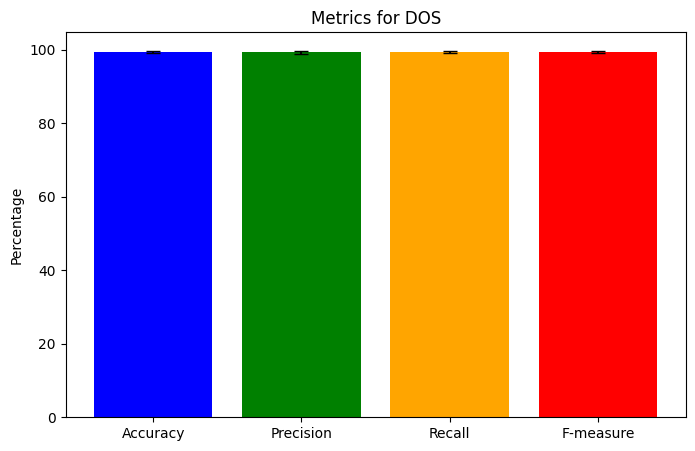

Probe
---------------
Accuracy: 98.59052% (+/- 0.45107%)
Precision: 97.56787% (+/- 0.78239%)
Recall: 98.04990% (+/- 0.80725%)
F-measure: 97.80515% (+/- 0.70362%)



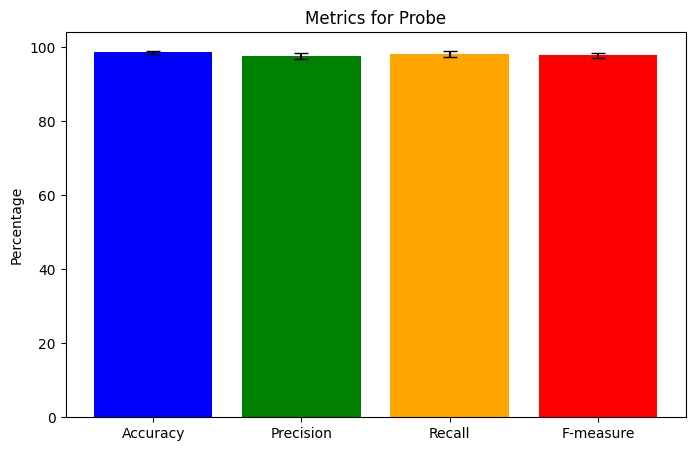

U2R
---------------
Accuracy: 99.55001% (+/- 0.27742%)
Precision: 93.62823% (+/- 17.02473%)
Recall: 70.21750% (+/- 18.83301%)
F-measure: 76.32887% (+/- 18.72380%)



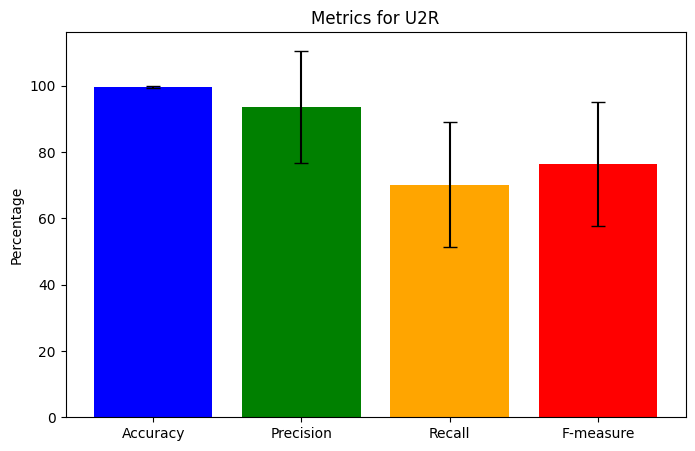

R2L
---------------
Accuracy: 96.74499% (+/- 0.70681%)
Precision: 94.85252% (+/- 1.08913%)
Recall: 96.11031% (+/- 1.24407%)
F-measure: 95.45597% (+/- 0.98503%)



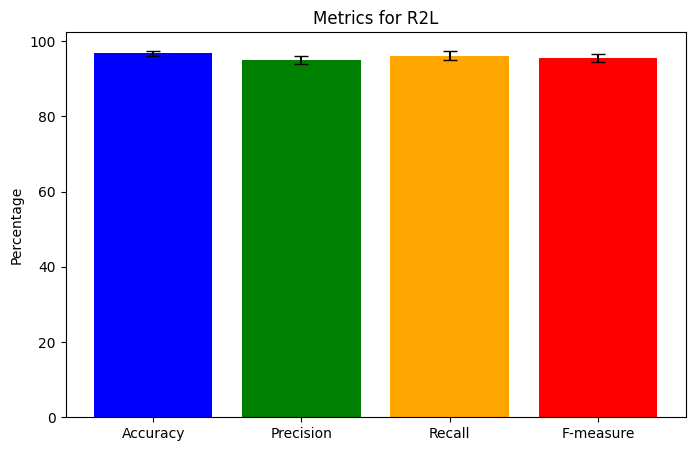


Naive Bayes Metrics:
DOS
---------------
Accuracy: 86.73344% (+/- 1.47436%)
Precision: 90.08126% (+/- 0.91452%)
Recall: 84.82976% (+/- 1.72122%)
F-measure: 85.79470% (+/- 1.70243%)



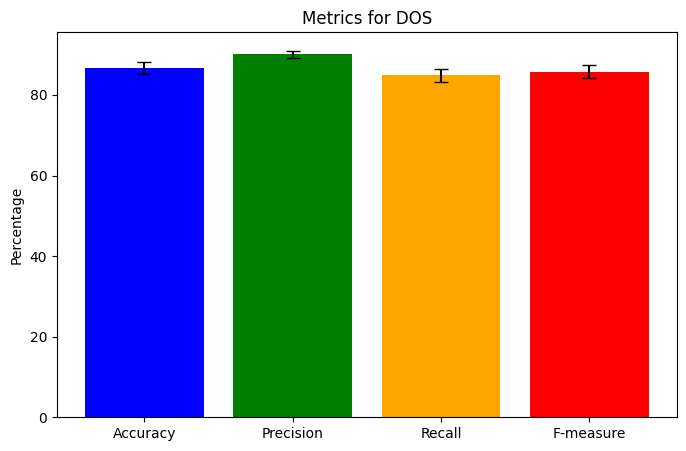

Probe
---------------
Accuracy: 97.89812% (+/- 1.14767%)
Precision: 97.32329% (+/- 0.91170%)
Recall: 96.05148% (+/- 3.03933%)
F-measure: 96.65402% (+/- 1.92528%)



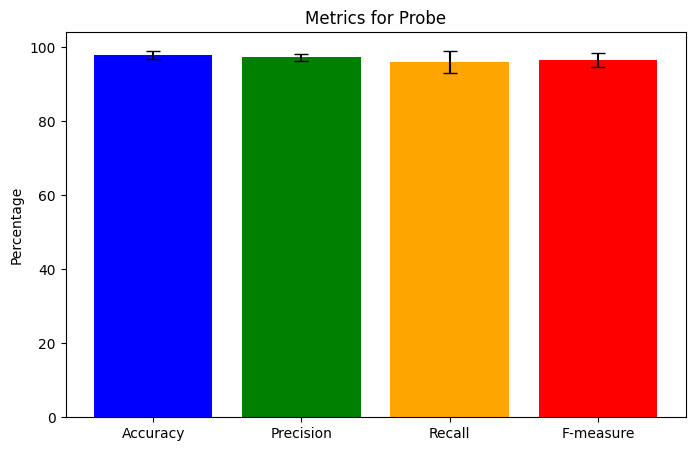

U2R
---------------
Accuracy: 97.25931% (+/- 1.12942%)
Precision: 60.15734% (+/- 3.25394%)
Recall: 97.91102% (+/- 4.29960%)
F-measure: 66.09117% (+/- 4.79043%)



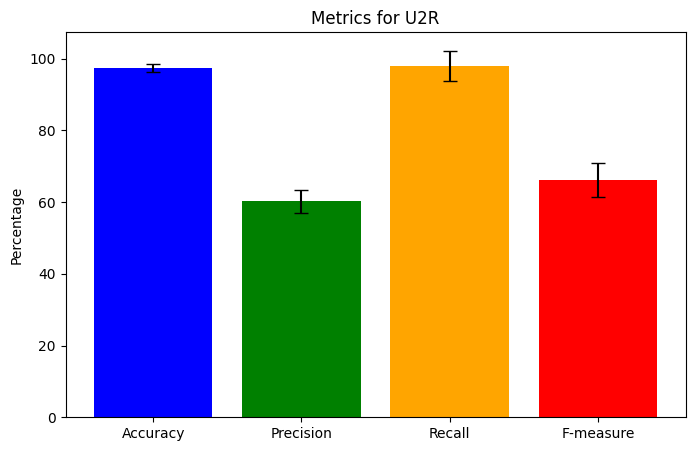

R2L
---------------
Accuracy: 93.56151% (+/- 1.00380%)
Precision: 89.09723% (+/- 1.36661%)
Recall: 95.50771% (+/- 0.77073%)
F-measure: 91.61998% (+/- 1.19998%)



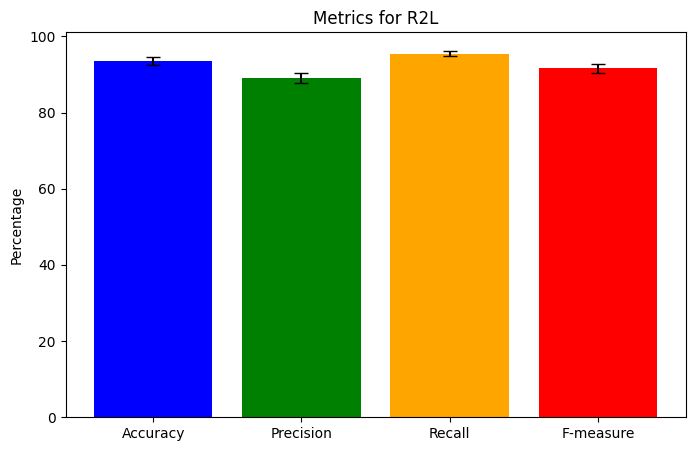

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt

# Create SVM and Naive Bayes classifiers
clf_SVM = SVC()
clf_NaiveBayes = GaussianNB()

def print_metrics(classifier, X, Y, class_name):
    accuracy = cross_val_score(classifier, X, Y, cv=10, scoring='accuracy')
    precision = cross_val_score(classifier, X, Y, cv=10, scoring='precision_macro')
    recall = cross_val_score(classifier, X, Y, cv=10, scoring='recall_macro')
    f_measure = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')

    print(class_name)
    print('---------------')
    print("Accuracy: %0.5f%% (+/- %0.5f%%)" % (accuracy.mean() * 100, accuracy.std() * 200))
    print("Precision: %0.5f%% (+/- %0.5f%%)" % (precision.mean() * 100, precision.std() * 200))
    print("Recall: %0.5f%% (+/- %0.5f%%)" % (recall.mean() * 100, recall.std() * 200))
    print("F-measure: %0.5f%% (+/- %0.5f%%)" % (f_measure.mean() * 100, f_measure.std() * 200))
    print()

    # Plotting
    labels = ['Accuracy', 'Precision', 'Recall', 'F-measure']
    values = [accuracy.mean() * 100, precision.mean() * 100, recall.mean() * 100, f_measure.mean() * 100]
    errors = [accuracy.std() * 200, precision.std() * 200, recall.std() * 200, f_measure.std() * 200]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, yerr=errors, capsize=5, color=['blue', 'green', 'orange', 'red'])
    plt.title(f'Metrics for {class_name}')
    plt.ylabel('Percentage')
    plt.show()

print("SVM Metrics:")
print_metrics(clf_SVM, X_DoS_test, Y_DoS_test, 'DOS')
print_metrics(clf_SVM, X_Probe_test, Y_Probe_test, 'Probe')
print_metrics(clf_SVM, X_U2R_test, Y_U2R_test, 'U2R')
print_metrics(clf_SVM, X_R2L_test, Y_R2L_test, 'R2L')

print("\nNaive Bayes Metrics:")
print_metrics(clf_NaiveBayes, X_DoS_test, Y_DoS_test, 'DOS')
print_metrics(clf_NaiveBayes, X_Probe_test, Y_Probe_test, 'Probe')
print_metrics(clf_NaiveBayes, X_U2R_test, Y_U2R_test, 'U2R')
print_metrics(clf_NaiveBayes, X_R2L_test, Y_R2L_test, 'R2L')



# Comparsion between models

KNN
---------------
Accuracy: 98.66673% (+/- 1.10468%)
Precision: 93.63262% (+/- 7.24126%)
Recall: 88.71162% (+/- 5.95326%)
F-measure: 90.35850% (+/- 6.48114%)

SVM
---------------
Accuracy: 97.85013% (+/- 0.82762%)
Precision: 95.36384% (+/- 7.20411%)
Recall: 82.90621% (+/- 8.18496%)
F-measure: 86.25699% (+/- 7.55259%)

Ensemble
---------------
Accuracy: 99.32466% (+/- 0.71285%)
Precision: 97.66293% (+/- 5.76315%)
Recall: 95.23992% (+/- 5.24632%)
F-measure: 96.03948% (+/- 4.68043%)

Naive Bayes
---------------
Accuracy: 81.33104% (+/- 40.60229%)
Precision: 83.54657% (+/- 10.39291%)
Recall: 94.21722% (+/- 10.64487%)
F-measure: 82.83473% (+/- 13.22069%)

Random Forest
---------------
Accuracy: 99.32079% (+/- 0.74085%)
Precision: 97.58106% (+/- 5.84508%)
Recall: 94.34611% (+/- 5.25959%)
F-measure: 95.92540% (+/- 3.69749%)



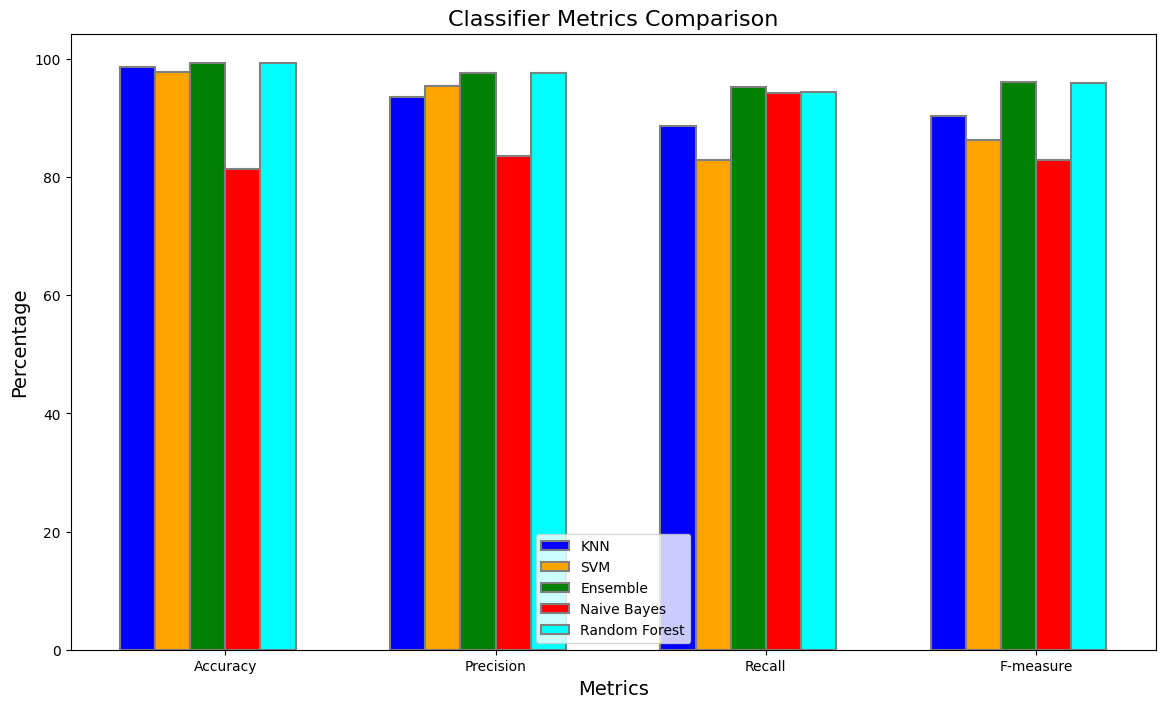

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Create classifiers
clf_Ensemble = RandomForestClassifier()
clf_NaiveBayes = GaussianNB()
clf_SVM = SVC()
clf_KNN = KNeighborsClassifier()
clf_RandomForest = RandomForestClassifier()

def print_metrics(classifier, X, Y, class_name):
    accuracy = cross_val_score(classifier, X, Y, cv=10, scoring='accuracy')
    precision = cross_val_score(classifier, X, Y, cv=10, scoring='precision_macro')
    recall = cross_val_score(classifier, X, Y, cv=10, scoring='recall_macro')
    f_measure = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')

    print(class_name)
    print('---------------')
    print("Accuracy: %0.5f%% (+/- %0.5f%%)" % (accuracy.mean() * 100, accuracy.std() * 200))
    print("Precision: %0.5f%% (+/- %0.5f%%)" % (precision.mean() * 100, precision.std() * 200))
    print("Recall: %0.5f%% (+/- %0.5f%%)" % (recall.mean() * 100, recall.std() * 200))
    print("F-measure: %0.5f%% (+/- %0.5f%%)" % (f_measure.mean() * 100, f_measure.std() * 200))
    print()

    return accuracy.mean() * 100, precision.mean() * 100, recall.mean() * 100, f_measure.mean() * 100

# Combine your datasets here
X_combined = np.vstack((X_DoS_test, X_Probe_test, X_R2L_test, X_U2R_test))
Y_combined = np.hstack((Y_DoS_test, Y_Probe_test, Y_R2L_test, Y_U2R_test))

# Collect metrics for each classifier
knn_metrics = print_metrics(clf_KNN, X_combined, Y_combined, 'KNN')
svm_metrics = print_metrics(clf_SVM, X_combined, Y_combined, 'SVM')
ensemble_metrics = print_metrics(clf_Ensemble, X_combined, Y_combined, 'Ensemble')
naive_bayes_metrics = print_metrics(clf_NaiveBayes, X_combined, Y_combined, 'Naive Bayes')
random_forest_metrics = print_metrics(clf_RandomForest, X_combined, Y_combined, 'Random Forest')

# Plotting
labels = ['Accuracy', 'Precision', 'Recall', 'F-measure']
knn_values = knn_metrics
svm_values = svm_metrics
ensemble_values = ensemble_metrics
naive_bayes_values = naive_bayes_metrics
random_forest_values = random_forest_metrics

bar_width = 0.13
index = np.arange(len(labels))

plt.figure(figsize=(14, 8))
plt.bar(index, knn_values, bar_width, label='KNN', color='blue', edgecolor='grey', linewidth=1.5)
plt.bar(index + bar_width, svm_values, bar_width, label='SVM', color='orange', edgecolor='grey', linewidth=1.5)
plt.bar(index + 2 * bar_width, ensemble_values, bar_width, label='Ensemble', color='green', edgecolor='grey', linewidth=1.5)
plt.bar(index + 3 * bar_width, naive_bayes_values, bar_width, label='Naive Bayes', color='red', edgecolor='grey', linewidth=1.5)
plt.bar(index + 4 * bar_width, random_forest_values, bar_width, label='Random Forest', color='cyan', edgecolor='grey', linewidth=1.5)

plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.title('Classifier Metrics Comparison', fontsize=16)
plt.xticks(index + 2.5 * bar_width, labels)
plt.legend()
plt.show()


# Confusion matrices
**comparing to all models**

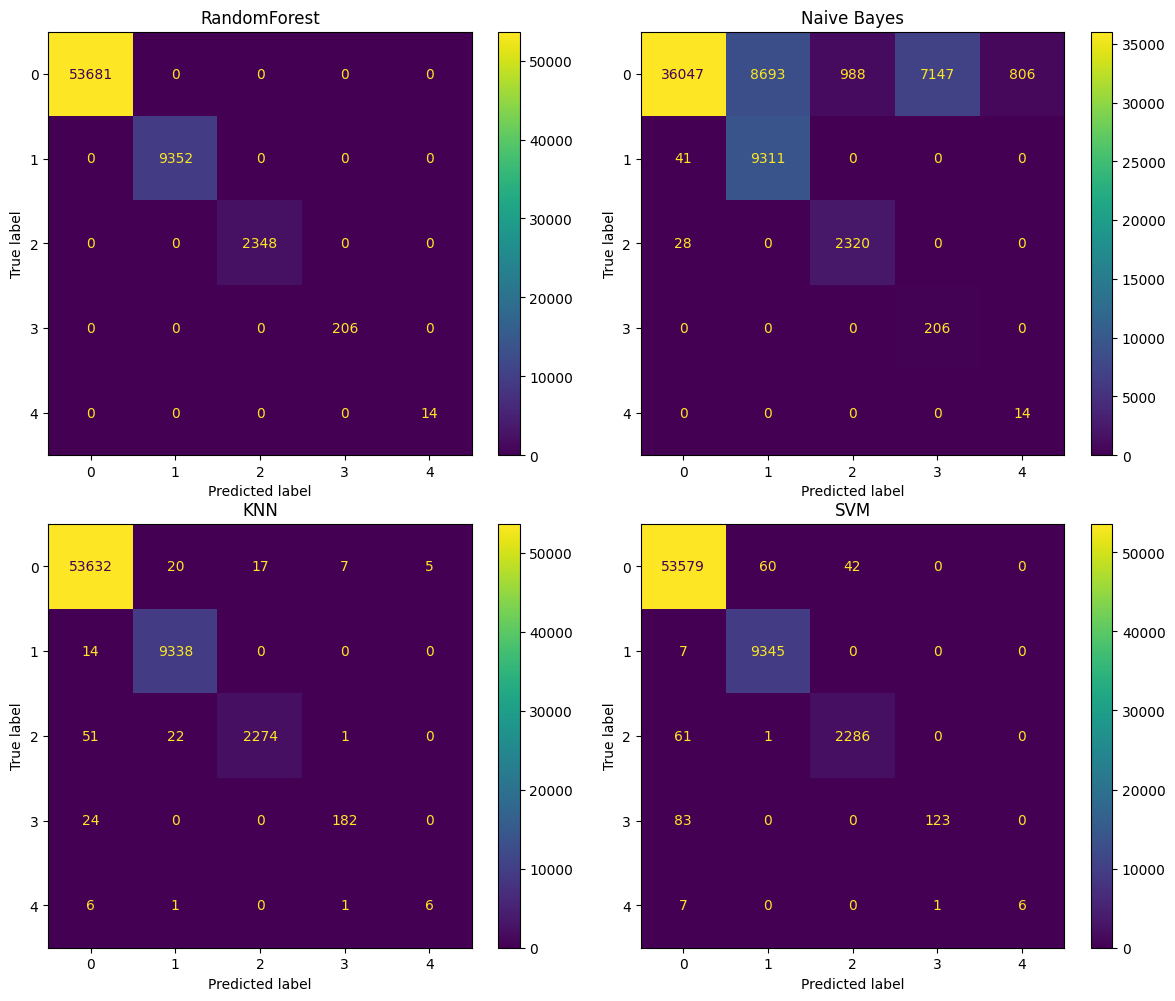

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

# Split the data into training and testing sets
# Assuming X_DoS, Y_DoS, X_Probe, Y_Probe, X_R2L, Y_R2L, X_U2R, Y_U2R are defined earlier
X_DoS_train, X_DoS_test, Y_DoS_train, Y_DoS_test = train_test_split(X_DoS, Y_DoS, test_size=0.2, random_state=42)
X_Probe_train, X_Probe_test, Y_Probe_train, Y_Probe_test = train_test_split(X_Probe, Y_Probe, test_size=0.2, random_state=42)
X_R2L_train, X_R2L_test, Y_R2L_train, Y_R2L_test = train_test_split(X_R2L, Y_R2L, test_size=0.2, random_state=42)
X_U2R_train, X_U2R_test, Y_U2R_train, Y_U2R_test = train_test_split(X_U2R, Y_U2R, test_size=0.2, random_state=42)

# Combine test sets
X_combined = np.vstack((X_DoS_test, X_Probe_test, X_R2L_test, X_U2R_test))
Y_combined = np.hstack((Y_DoS_test, Y_Probe_test, Y_R2L_test, Y_U2R_test))

# Define classifiers
clf_RF = RandomForestClassifier()
clf_NB = GaussianNB()
clf_KNN = KNeighborsClassifier(n_neighbors=5)
clf_SVM = SVC()

# Train the classifiers
clf_RF.fit(X_combined, Y_combined)
clf_NB.fit(X_combined, Y_combined)
clf_KNN.fit(X_combined, Y_combined)
clf_SVM.fit(X_combined, Y_combined)

# Make predictions
Y_RF_pred = clf_RF.predict(X_combined)
Y_NB_pred = clf_NB.predict(X_combined)
Y_KNN_pred = clf_KNN.predict(X_combined)
Y_SVM_pred = clf_SVM.predict(X_combined)

# Create confusion matrices
cm_RF = confusion_matrix(Y_combined, Y_RF_pred)
cm_NB = confusion_matrix(Y_combined, Y_NB_pred)
cm_KNN = confusion_matrix(Y_combined, Y_KNN_pred)
cm_SVM = confusion_matrix(Y_combined, Y_SVM_pred)

# Plot the confusion matrices in subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# RandomForest
disp_RF = ConfusionMatrixDisplay(confusion_matrix=cm_RF, display_labels=np.unique(Y_combined))
disp_RF.plot(ax=axes[0, 0])
axes[0, 0].set_title('RandomForest')

# Naive Bayes
disp_NB = ConfusionMatrixDisplay(confusion_matrix=cm_NB, display_labels=np.unique(Y_combined))
disp_NB.plot(ax=axes[0, 1])
axes[0, 1].set_title('Naive Bayes')

# K-Nearest Neighbors
disp_KNN = ConfusionMatrixDisplay(confusion_matrix=cm_KNN, display_labels=np.unique(Y_combined))
disp_KNN.plot(ax=axes[1, 0])
axes[1, 0].set_title('KNN')

# SVM
disp_SVM = ConfusionMatrixDisplay(confusion_matrix=cm_SVM, display_labels=np.unique(Y_combined))
disp_SVM.plot(ax=axes[1, 1])
axes[1, 1].set_title('SVM')

plt.tight_layout()
plt.show()
